# End-to-end Privacy Preserving Training and Inference on Medical Data 

## Introduction
In this tutorial, we will demonstrate the process of privacy-preserving training using Fed-BioMed, which leverages federated learning with secure aggregation. Subsequently, we will deploy the final model obtained through federated learning in a privacy-preserving manner using the [Concrete-ML](https://github.com/zama-ai/concrete-ml) library. This approach allows us to achieve privacy-preserving inference through a software-as-a-service (SaaS) model.

The selected dataset originates from a medical task assigned by [Flamby](https://github.com/owkin/FLamby), specifically the FedHeart Disease dataset. For more detailed information about the dataset, please refer to the provided [link](https://github.com/owkin/FLamby/blob/main/flamby/datasets/fed_heart_disease/README.md).

## Install Concrete-ML

This tutorial assumes you have Concrete-ML installed in your Fed-BioMed researcher environment. 

If needed, you may install it with:
1. `source ${FEDBIOMED_DIR}/scripts/fedbiomed_environment researcher`
2. `pip install concrete-ml`

### Note for MacOS users with ARM chips

If you have a recent Mac machine with Apple Silicon (ARM chips), then you may experience kernel failure in Section 3.2 of this notebook. 

To overcome this issue, you need to rebuild your conda `fedbiomed-researcher` environment with a native python executable, before installing Concrete-ML. This process may take some time. 

1. `export CONDA_SUBDIR=osx-arm64`
2. `${FEDBIOMED_DIR}/scripts/configure_conda -c researcher`

## Task: identify patients with heart disease

We rely on the FedHeart dataset and task from [FLamby](https://github.com/owkin/FLamby), in which tabular patient data as input is used to predict the presence or absence of heart disease. More details can be found in FLamby's [paper](https://openreview.net/pdf?id=GgM5DiAb6A2).

### FLamby configuration - Download FedHeart

You need to download the FLamby dataset that we will use. For licensing reasons, these are not included directly in the FLamby installation.

To download the fed_heart dataset in `${FEDBIOMED_DIR}/data` (where `${FEDBIOMED_DIR}` is the base directory of Fed-BioMed): 

1. `source ${FEDBIOMED_DIR}/scripts/fedbiomed_environment node`<br>
2. `pip install wget`<br>
3. `python ${FEDBIOMED_DIR}/docs/tutorials/concrete-ml/download.py --output-folder ${FEDBIOMED_DIR}/data`

In [1]:
import os
import torch 
from torch.utils.data import DataLoader
import numpy as np
from fedbiomed.common.training_plans import TorchTrainingPlan
from flamby.datasets.fed_heart_disease import FedHeartDisease
from fedbiomed.common.data import FlambyDataset, DataManager
# from concrete.ml.torch.compile import compile_torch_model
from torch.nn.modules.loss import _Loss
import torch.nn as nn
from fedbiomed.researcher.environ import environ
tensorboard_dir = environ['TENSORBOARD_RESULTS_DIR']

In [2]:
FEDBIOMED_DIR = os.getenv('FEDBIOMED_DIR')
DATASET_TEST_PATH = f"{FEDBIOMED_DIR}/data"

## 1. Fed-BioMed

Configuring the Fed-BioMed training plan involves specifying the machine learning model, defining the loss function, and identifying the necessary dependencies. This ensures a clear and well-defined setup for the training process.

In [3]:
%load_ext tensorboard

In [4]:
class FedHeartTrainingPlan(TorchTrainingPlan):
    
    class Baseline(nn.Module):
        
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(13, 16)
            self.fc2 = nn.Linear(16, 2)
            self.act = nn.LeakyReLU()
        def forward(self, x):
            x = self.act(self.fc1(x))
            x = self.fc2(x)
            return x
        
    class BaselineLoss(_Loss):
        def __init__(self):
            super().__init__()
            self.ce = torch.nn.CrossEntropyLoss()

        def forward(self, prediction: torch.Tensor, target: torch.Tensor):
            target = torch.squeeze(target, dim=1).type(torch.long)
            return self.ce(prediction, target)
    
    def init_model(self, model_args):
        return self.Baseline()

    def init_optimizer(self, optimizer_args):
        return torch.optim.AdamW(self.model().parameters(), lr=optimizer_args["lr"])

    def init_dependencies(self):
        return ["from flamby.datasets.fed_heart_disease import FedHeartDisease",
                "from torch.nn.modules.loss import _Loss",
                "from fedbiomed.common.data import FlambyDataset, DataManager"]

    def training_step(self, data, target):
        logits = self.model().forward(data)
        return self.BaselineLoss().forward(logits, target)

    def training_data(self, batch_size=2):
        dataset = FlambyDataset()
        train_kwargs = {'batch_size': batch_size, 'shuffle': True}
        return DataManager(dataset, **train_kwargs)

In [5]:
batch_size = 8
num_updates = 10
num_rounds = 50

In [6]:
training_args = {
    'optimizer_args': {
        'lr': 5e-4,
    },
    'loader_args': {
        'batch_size': batch_size,
    },
    'num_updates': num_updates,
    'dry_run': False,
    'log_interval': 2,
    'test_ratio' : 0.0,
    'test_on_global_updates': False,
    'test_on_local_updates': False,
    'random_seed':42,
}

model_args = {}

## 2. Federated Learning Training with SecAgg

**Nodes Configuration:**
The FLamby Fed-Heart benchmark relies on 4 nodes.
For each node in the range `i in [0...3]` (`0` and `3` are both included):

1. Open a new terminal.
2. Run the command: `./scripts/fedbiomed_run node --config config-n{i}.ini dataset add`
3. Select `6) flamby`.
4. Enter the dataset name: `flamby` (optional).
5. Set tags to: `heart` (important).
6. Description: Enter `none` (optional).
7. Select `1) fed_heart_disease`.
8. Specify a center ID between 0 and 3: `{i}`.
9. Description: Enter `none` (optional).
10. Run the command: `./scripts/fedbiomed_run node --config config-n{i}.ini start`.

### Configuring Secure Aggregation

If you haven't done so already, you need to configure SecAgg in Fed-BioMed. 
A quick reminder of the basic commands is given below, but please refer to our documentation for a full explanation.

1. `${FEDBIOMED_DIR}/scripts/fedbiomed_configure_secagg researcher`
2. make sure the researcher and nodes' config files have been created (e.g. step 2 above)
3. `${FEDBIOMED_DIR}/scripts/fedbiomed_run certificate-dev-setup`


In [7]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

tags =  ['heart']

exp_sec_agg = Experiment(tags=tags,
                 training_plan_class=FedHeartTrainingPlan,
                 training_args=training_args,
                 model_args=model_args,
                 round_limit=num_rounds,
                 aggregator=FedAverage(),
                 secagg=True,
                 tensorboard=True
                )

2024-05-24 17:30:02,844 fedbiomed WARNING - Importing Experiment class from the researcher package has been deprecated. Please use the following import statement instead:
from fedbiomed.researcher.federated_workflows import Experiment

2024-05-24 17:30:02,855 fedbiomed INFO - Starting researcher service...

2024-05-24 17:30:02,856 fedbiomed INFO - Waiting 3s for nodes to connect...

2024-05-24 17:30:04,175 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:04,177 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:04,178 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:04,179 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:05,861 fedbiomed INFO - Updating training data. This action will update FederatedDataset, and the nodes that will participate to the experiment.

2024-05-24 17:30:05,882 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:05,890 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:05,894 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:05,898 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:05,909 fedbiomed INFO - Node selected for training -> NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8

2024-05-24 17:30:05,910 fedbiomed INFO - Node selected for training -> NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4

2024-05-24 17:30:05,912 fedbiomed INFO - Node selected for training -> NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42

2024-05-24 17:30:05,913 fedbiomed INFO - Node selected for training -> NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30

2024-05-24 17:30:05,917 fedbiomed DEBUG - Model file has been saved: /workspaces/Projects/fedbiomed/var/experiments/Experiment_0018/model_ab0e299f-892d-4a0c-9f0c-78b64951cd02.py

Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.


2024-05-24 17:30:05,922 fedbiomed INFO - Removing tensorboard logs from previous experiment

In [8]:
tensorboard --logdir "$tensorboard_dir"

In our example, the training loss curve for the 4 nodes looks like this:
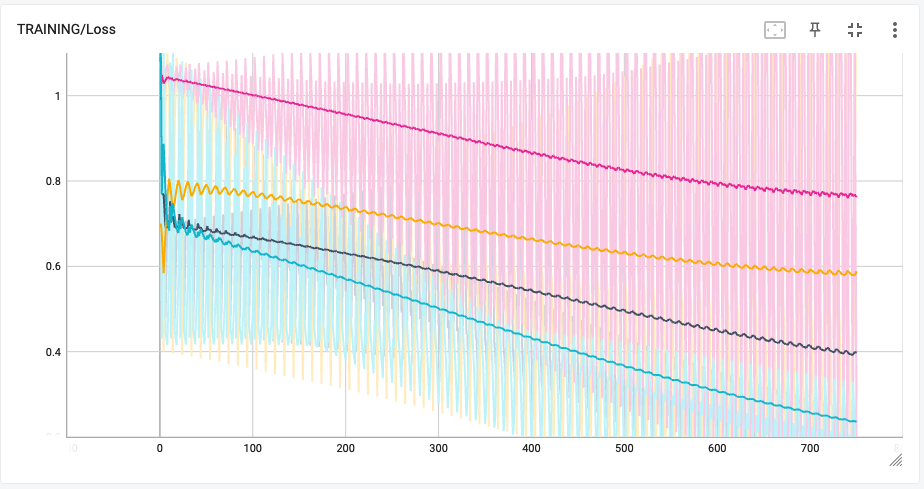

In [9]:
exp_sec_agg.run()

2024-05-24 17:30:09,884 fedbiomed DEBUG - Secagg context for default_biprime0 is already existing on researcher researcher_id='RESEARCHER_596f170d-96d8-417a-8ddf-9bdb1cf7d52b'

2024-05-24 17:30:09,891 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:09,899 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:09,904 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:09,905 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:09,914 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:09,918 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:09,920 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:09,931 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:13,726 fedbiomed DEBUG - MPC protocol output: 
						 Cloning MP-SPDZ into the MPC working directory ...
						
						Doing /workspaces/Projects/fedbiomed/var/tmp/MPC/RESEARCHER_596f170d-96d8-417a-8ddf-9bdb1cf7d52b/d0459832-d49f-4818-9b4d-5d7f88320655/MP-SPDZ/Player-Data
						Compiling 'server_key'...
						
						Compilation is successful!
						##########################################################################
						Default bit length: 2048
						Default security parameter: 40
						Compiling: server_key from compile_func
						Writing to /workspaces/Projects/fedbiomed/var/tmp/MPC/RESEARCHER_596f170d-96d8-417a-8ddf-9bdb1cf7d52b/d0459832-d49f-4818-9b4d-5d7f88320655/MP-SPDZ/Programs/Schedules/server_key.sch
						Writing to /workspaces/Projects/fedbiomed/var/tmp/MPC/RESEARCHER_596f170d-96d8-417a-8ddf-9bdb1cf7d52b/d0459832-d49f-4818-9b4d-5d7f88320655/MP-SPDZ/Programs/Bytecode/server_key-0.bc
						Program requires at most:
						         inf integer inputs from

2024-05-24 17:30:13,732 fedbiomed DEBUG - Server key successfully created for researcher_id='RESEARCHER_596f170d-96d8-417a-8ddf-9bdb1cf7d52b' secagg_id='secagg_3ea20977-43c4-4a23-92a3-85c2b1b63a0e'

2024-05-24 17:30:13,744 fedbiomed INFO - Sampled nodes in round 0 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:13,746 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:13,747 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:13,748 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:13,749 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:13,762 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:13,768 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:13,773 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:13,776 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:13,974 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 1 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 1.110733 
					 ---------

2024-05-24 17:30:13,985 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 1 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 1.100353 
					 ---------

2024-05-24 17:30:13,995 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 1 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.430853 
					 ---------

2024-05-24 17:30:14,000 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 1 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.444833 
					 ---------

2024-05-24 17:30:14,018 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 1 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.700822 
					 ---------

2024-05-24 17:30:14,025 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 1 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 1.120486 
					 ---------

2024-05-24 17:30:14,037 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 1 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.654252 
					 ---------

2024-05-24 17:30:14,039 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 1 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.762766 
					 ---------

2024-05-24 17:30:14,053 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 1 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.447183 
					 ---------

2024-05-24 17:30:14,063 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 1 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.400192 
					 ---------

2024-05-24 17:30:14,073 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 1 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.415360 
					 ---------

2024-05-24 17:30:14,085 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 1 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.950729 
					 ---------

2024-05-24 17:30:14,098 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 1 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.460538 
					 ---------

2024-05-24 17:30:14,113 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 1 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.099793 
					 ---------

2024-05-24 17:30:14,129 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 1 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 1.010768 
					 ---------

2024-05-24 17:30:14,133 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 1 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 1.026978 
					 ---------

2024-05-24 17:30:14,139 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:14,145 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 1 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.594064 
					 ---------

2024-05-24 17:30:14,146 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 1 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.699862 
					 ---------

2024-05-24 17:30:14,150 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:14,154 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 1 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.069686 
					 ---------

2024-05-24 17:30:14,169 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 1 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.988860 
					 ---------

2024-05-24 17:30:14,188 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 1 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.716280 
					 ---------

2024-05-24 17:30:14,196 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:14,198 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:14,210 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 1 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 1.057932 
					 ---------

2024-05-24 17:30:14,225 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 1 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.072667 
					 ---------

2024-05-24 17:30:14,227 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:14,232 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:14,251 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 1 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 1.035710 
					 ---------

2024-05-24 17:30:14,268 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:14,273 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:14,290 fedbiomed INFO - Nodes that successfully reply in round 0 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:14,292 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:14,301 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:14,302 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:14,303 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:14,304 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:14,345 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:14,346 fedbiomed DEBUG - Aggregation is completed in 0.04 seconds.

2024-05-24 17:30:14,348 fedbiomed INFO - Sampled nodes in round 1 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:14,350 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:14,350 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:14,351 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:14,352 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:14,363 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:14,366 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:14,368 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:14,370 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:14,553 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 2 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 1.016256 
					 ---------

2024-05-24 17:30:14,557 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 2 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.071112 
					 ---------

2024-05-24 17:30:14,570 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 2 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.986292 
					 ---------

2024-05-24 17:30:14,580 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 2 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 1.077076 
					 ---------

2024-05-24 17:30:14,584 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 2 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 1.038392 
					 ---------

2024-05-24 17:30:14,610 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 2 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 1.077539 
					 ---------

2024-05-24 17:30:14,626 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 2 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.069170 
					 ---------

2024-05-24 17:30:14,636 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 2 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.697820 
					 ---------

2024-05-24 17:30:14,644 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 2 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 1.017637 
					 ---------

2024-05-24 17:30:14,647 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 2 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.443754 
					 ---------

2024-05-24 17:30:14,653 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:14,659 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 2 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.431393 
					 ---------

2024-05-24 17:30:14,677 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 2 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.652993 
					 ---------

2024-05-24 17:30:14,686 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:14,695 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 2 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.757199 
					 ---------

2024-05-24 17:30:14,713 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 2 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.396327 
					 ---------

2024-05-24 17:30:14,717 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 2 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 1.100420 
					 ---------

2024-05-24 17:30:14,729 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 2 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.461764 
					 ---------

2024-05-24 17:30:14,742 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 2 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.703696 
					 ---------

2024-05-24 17:30:14,764 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 2 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.940094 
					 ---------

2024-05-24 17:30:14,786 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 2 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.702309 
					 ---------

2024-05-24 17:30:14,790 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:14,801 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 2 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.448720 
					 ---------

2024-05-24 17:30:14,804 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 2 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.088266 
					 ---------

2024-05-24 17:30:14,813 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 2 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.415824 
					 ---------

2024-05-24 17:30:14,839 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 2 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 1.002917 
					 ---------

2024-05-24 17:30:14,845 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:14,853 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:14,863 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 2 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.581565 
					 ---------

2024-05-24 17:30:14,868 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:14,905 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:14,918 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:14,940 fedbiomed INFO - Nodes that successfully reply in round 1 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:14,941 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:14,946 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:14,947 fedbiomed DEBUG - Aggregation is completed in 0.0 seconds.

2024-05-24 17:30:14,948 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:14,949 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:14,995 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:14,997 fedbiomed DEBUG - Aggregation is completed in 0.05 seconds.

2024-05-24 17:30:14,999 fedbiomed INFO - Sampled nodes in round 2 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:15,002 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:15,004 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:15,005 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:15,006 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:15,019 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:15,022 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:15,023 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:15,025 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:15,239 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 3 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 1.045134 
					 ---------

2024-05-24 17:30:15,245 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 3 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.431721 
					 ---------

2024-05-24 17:30:15,250 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 3 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 1.005773 
					 ---------

2024-05-24 17:30:15,258 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 3 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.072742 
					 ---------

2024-05-24 17:30:15,276 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 3 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.694922 
					 ---------

2024-05-24 17:30:15,294 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 3 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.651757 
					 ---------

2024-05-24 17:30:15,300 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 3 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.983994 
					 ---------

2024-05-24 17:30:15,307 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 3 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 1.054232 
					 ---------

2024-05-24 17:30:15,332 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 3 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.392371 
					 ---------

2024-05-24 17:30:15,335 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 3 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.442545 
					 ---------

2024-05-24 17:30:15,346 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 3 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 1.080396 
					 ---------

2024-05-24 17:30:15,363 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 3 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 1.019096 
					 ---------

2024-05-24 17:30:15,371 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 3 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.751720 
					 ---------

2024-05-24 17:30:15,384 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 3 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.929585 
					 ---------

2024-05-24 17:30:15,394 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 3 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.450242 
					 ---------

2024-05-24 17:30:15,403 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 3 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.462779 
					 ---------

2024-05-24 17:30:15,429 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 3 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.065795 
					 ---------

2024-05-24 17:30:15,431 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 3 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.076937 
					 ---------

2024-05-24 17:30:15,447 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 3 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.707512 
					 ---------

2024-05-24 17:30:15,463 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 3 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.995280 
					 ---------

2024-05-24 17:30:15,474 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 3 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.999982 
					 ---------

2024-05-24 17:30:15,477 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:15,479 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 3 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.416248 
					 ---------

2024-05-24 17:30:15,489 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:15,516 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 3 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.688406 
					 ---------

2024-05-24 17:30:15,520 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:15,529 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 3 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.569333 
					 ---------

2024-05-24 17:30:15,534 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:15,540 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:15,557 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:15,576 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:15,581 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:15,600 fedbiomed INFO - Nodes that successfully reply in round 2 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:15,601 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:15,605 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:15,606 fedbiomed DEBUG - Aggregation is completed in 0.0 seconds.

2024-05-24 17:30:15,607 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:15,608 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:15,639 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:15,640 fedbiomed DEBUG - Aggregation is completed in 0.03 seconds.

2024-05-24 17:30:15,643 fedbiomed INFO - Sampled nodes in round 3 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:15,645 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:15,646 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:15,648 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:15,648 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:15,656 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:15,658 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:15,660 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:15,662 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:15,784 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 4 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.995405 
					 ---------

2024-05-24 17:30:15,790 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 4 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.074433 
					 ---------

2024-05-24 17:30:15,799 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 4 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.981846 
					 ---------

2024-05-24 17:30:15,806 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 4 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.999888 
					 ---------

2024-05-24 17:30:15,837 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 4 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.692098 
					 ---------

2024-05-24 17:30:15,844 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 4 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.062459 
					 ---------

2024-05-24 17:30:15,848 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 4 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.650738 
					 ---------

2024-05-24 17:30:15,855 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 4 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.982179 
					 ---------

2024-05-24 17:30:15,860 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 4 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 1.031630 
					 ---------

2024-05-24 17:30:15,867 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 4 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 1.013226 
					 ---------

2024-05-24 17:30:15,868 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 4 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.441295 
					 ---------

2024-05-24 17:30:15,872 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:15,873 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 4 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.388702 
					 ---------

2024-05-24 17:30:15,885 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:15,887 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 4 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.919912 
					 ---------

2024-05-24 17:30:15,900 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 4 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.065567 
					 ---------

2024-05-24 17:30:15,905 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 4 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.987718 
					 ---------

2024-05-24 17:30:15,912 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:15,919 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 4 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.746297 
					 ---------

2024-05-24 17:30:15,924 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 4 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.432029 
					 ---------

2024-05-24 17:30:15,940 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 4 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 1.060537 
					 ---------

2024-05-24 17:30:15,953 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 4 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.451796 
					 ---------

2024-05-24 17:30:15,955 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 4 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.463718 
					 ---------

2024-05-24 17:30:15,958 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 4 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.416656 
					 ---------

2024-05-24 17:30:15,961 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:15,971 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 4 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.557134 
					 ---------

2024-05-24 17:30:15,981 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 4 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.711441 
					 ---------

2024-05-24 17:30:15,984 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:15,989 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 4 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.676873 
					 ---------

2024-05-24 17:30:16,016 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:16,023 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:16,054 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:16,073 fedbiomed INFO - Nodes that successfully reply in round 3 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:16,074 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:16,079 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:16,080 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:16,080 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:16,081 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:16,110 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:16,111 fedbiomed DEBUG - Aggregation is completed in 0.03 seconds.

2024-05-24 17:30:16,113 fedbiomed INFO - Sampled nodes in round 4 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:16,116 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:16,116 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:16,118 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:16,118 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:16,129 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:16,132 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:16,134 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:16,135 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:16,357 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 5 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 1.009661 
					 ---------

2024-05-24 17:30:16,371 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 5 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.689300 
					 ---------

2024-05-24 17:30:16,383 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 5 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.649854 
					 ---------

2024-05-24 17:30:16,395 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 5 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.439922 
					 ---------

2024-05-24 17:30:16,401 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 5 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.981850 
					 ---------

2024-05-24 17:30:16,418 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 5 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.985416 
					 ---------

2024-05-24 17:30:16,430 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 5 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.432159 
					 ---------

2024-05-24 17:30:16,435 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 5 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.384492 
					 ---------

2024-05-24 17:30:16,438 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 5 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.076378 
					 ---------

2024-05-24 17:30:16,445 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 5 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.741120 
					 ---------

2024-05-24 17:30:16,464 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 5 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.910077 
					 ---------

2024-05-24 17:30:16,471 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 5 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.979919 
					 ---------

2024-05-24 17:30:16,493 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 5 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.464488 
					 ---------

2024-05-24 17:30:16,502 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 5 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 1.041106 
					 ---------

2024-05-24 17:30:16,511 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 5 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.980576 
					 ---------

2024-05-24 17:30:16,515 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 5 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.054460 
					 ---------

2024-05-24 17:30:16,544 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 5 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.980609 
					 ---------

2024-05-24 17:30:16,554 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 5 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.715130 
					 ---------

2024-05-24 17:30:16,557 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:16,566 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 5 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.059255 
					 ---------

2024-05-24 17:30:16,577 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 5 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.965414 
					 ---------

2024-05-24 17:30:16,586 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:16,590 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 5 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.666707 
					 ---------

2024-05-24 17:30:16,593 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 5 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.453358 
					 ---------

2024-05-24 17:30:16,597 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:16,613 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:16,625 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 5 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.416871 
					 ---------

2024-05-24 17:30:16,632 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 5 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.544941 
					 ---------

2024-05-24 17:30:16,638 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:16,658 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:16,660 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:16,685 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:16,702 fedbiomed INFO - Nodes that successfully reply in round 4 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:16,703 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:16,707 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:16,708 fedbiomed DEBUG - Aggregation is completed in 0.0 seconds.

2024-05-24 17:30:16,709 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:16,710 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:16,741 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:16,742 fedbiomed DEBUG - Aggregation is completed in 0.03 seconds.

2024-05-24 17:30:16,744 fedbiomed INFO - Sampled nodes in round 5 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:16,745 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:16,746 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:16,747 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:16,747 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:16,755 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:16,758 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:16,760 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:16,764 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:16,956 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 6 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.975763 
					 ---------

2024-05-24 17:30:16,964 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 6 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.950934 
					 ---------

2024-05-24 17:30:16,972 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 6 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.078322 
					 ---------

2024-05-24 17:30:16,990 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 6 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.686537 
					 ---------

2024-05-24 17:30:16,994 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 6 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.648955 
					 ---------

2024-05-24 17:30:16,998 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 6 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.432083 
					 ---------

2024-05-24 17:30:17,007 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 6 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.987877 
					 ---------

2024-05-24 17:30:17,014 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 6 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.380011 
					 ---------

2024-05-24 17:30:17,020 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 6 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.438361 
					 ---------

2024-05-24 17:30:17,030 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 6 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.978287 
					 ---------

2024-05-24 17:30:17,036 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 6 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 1.019660 
					 ---------

2024-05-24 17:30:17,040 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 6 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.900577 
					 ---------

2024-05-24 17:30:17,063 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 6 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.961328 
					 ---------

2024-05-24 17:30:17,075 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 6 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.454780 
					 ---------

2024-05-24 17:30:17,085 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 6 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.043622 
					 ---------

2024-05-24 17:30:17,114 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 6 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.056131 
					 ---------

2024-05-24 17:30:17,120 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 6 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.736200 
					 ---------

2024-05-24 17:30:17,132 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 6 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.417000 
					 ---------

2024-05-24 17:30:17,145 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 6 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.533261 
					 ---------

2024-05-24 17:30:17,154 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:17,159 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 6 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.973569 
					 ---------

2024-05-24 17:30:17,170 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:17,179 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 6 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.949182 
					 ---------

2024-05-24 17:30:17,208 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 6 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.464932 
					 ---------

2024-05-24 17:30:17,214 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:17,223 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:17,227 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:17,228 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 6 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.718298 
					 ---------

2024-05-24 17:30:17,245 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 6 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.656823 
					 ---------

2024-05-24 17:30:17,258 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:17,280 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:17,305 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:17,324 fedbiomed INFO - Nodes that successfully reply in round 5 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:17,327 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:17,335 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:17,336 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:17,337 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:17,337 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:17,369 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:17,370 fedbiomed DEBUG - Aggregation is completed in 0.03 seconds.

2024-05-24 17:30:17,372 fedbiomed INFO - Sampled nodes in round 6 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:17,374 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:17,375 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:17,376 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:17,377 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:17,388 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:17,390 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:17,392 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:17,394 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:17,627 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 7 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.683772 
					 ---------

2024-05-24 17:30:17,652 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 7 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.920419 
					 ---------

2024-05-24 17:30:17,664 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 7 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.431645 
					 ---------

2024-05-24 17:30:17,666 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 7 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.648036 
					 ---------

2024-05-24 17:30:17,678 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 7 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.966376 
					 ---------

2024-05-24 17:30:17,680 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 7 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.375561 
					 ---------

2024-05-24 17:30:17,703 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 7 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.998929 
					 ---------

2024-05-24 17:30:17,704 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 7 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.891220 
					 ---------

2024-05-24 17:30:17,717 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 7 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.966306 
					 ---------

2024-05-24 17:30:17,735 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 7 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.080366 
					 ---------

2024-05-24 17:30:17,737 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 7 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.033054 
					 ---------

2024-05-24 17:30:17,760 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 7 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.456009 
					 ---------

2024-05-24 17:30:17,762 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 7 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.976684 
					 ---------

2024-05-24 17:30:17,768 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 7 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.966662 
					 ---------

2024-05-24 17:30:17,774 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 7 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.436731 
					 ---------

2024-05-24 17:30:17,776 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:17,777 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 7 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.943433 
					 ---------

2024-05-24 17:30:17,783 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:17,786 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 7 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.731159 
					 ---------

2024-05-24 17:30:17,806 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 7 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.053183 
					 ---------

2024-05-24 17:30:17,819 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 7 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.465318 
					 ---------

2024-05-24 17:30:17,839 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 7 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.721793 
					 ---------

2024-05-24 17:30:17,855 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 7 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.647028 
					 ---------

2024-05-24 17:30:17,859 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 7 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.933432 
					 ---------

2024-05-24 17:30:17,864 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:17,866 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:17,878 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 7 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.417145 
					 ---------

2024-05-24 17:30:17,899 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:17,911 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:17,926 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 7 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.521528 
					 ---------

2024-05-24 17:30:17,942 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:17,948 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:17,968 fedbiomed INFO - Nodes that successfully reply in round 6 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:17,971 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:17,980 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:17,983 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:17,984 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:17,986 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:18,020 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:18,021 fedbiomed DEBUG - Aggregation is completed in 0.03 seconds.

2024-05-24 17:30:18,023 fedbiomed INFO - Sampled nodes in round 7 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:18,025 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:18,025 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:18,026 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:18,026 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:18,035 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:18,041 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:18,043 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:18,045 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:18,182 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 8 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.890572 
					 ---------

2024-05-24 17:30:18,186 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 8 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.431424 
					 ---------

2024-05-24 17:30:18,208 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 8 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.978294 
					 ---------

2024-05-24 17:30:18,212 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 8 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.957325 
					 ---------

2024-05-24 17:30:18,220 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 8 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.457297 
					 ---------

2024-05-24 17:30:18,241 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 8 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.417100 
					 ---------

2024-05-24 17:30:18,244 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 8 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.082485 
					 ---------

2024-05-24 17:30:18,265 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 8 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.510077 
					 ---------

2024-05-24 17:30:18,269 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:18,273 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 8 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.975225 
					 ---------

2024-05-24 17:30:18,306 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 8 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.680937 
					 ---------

2024-05-24 17:30:18,311 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 8 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.925854 
					 ---------

2024-05-24 17:30:18,314 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:18,327 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 8 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.050527 
					 ---------

2024-05-24 17:30:18,333 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 8 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.647018 
					 ---------

2024-05-24 17:30:18,349 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 8 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.944841 
					 ---------

2024-05-24 17:30:18,355 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 8 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.434981 
					 ---------

2024-05-24 17:30:18,380 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 8 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.917328 
					 ---------

2024-05-24 17:30:18,385 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:18,392 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 8 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.371229 
					 ---------

2024-05-24 17:30:18,395 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 8 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.726251 
					 ---------

2024-05-24 17:30:18,410 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 8 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.465358 
					 ---------

2024-05-24 17:30:18,432 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 8 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.882173 
					 ---------

2024-05-24 17:30:18,436 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:18,448 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 8 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.022635 
					 ---------

2024-05-24 17:30:18,455 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 8 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.725391 
					 ---------

2024-05-24 17:30:18,458 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 8 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.959709 
					 ---------

2024-05-24 17:30:18,470 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:18,475 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 8 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.637998 
					 ---------

2024-05-24 17:30:18,504 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:18,518 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:18,527 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:18,550 fedbiomed INFO - Nodes that successfully reply in round 7 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:18,552 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:18,557 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:18,559 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:18,560 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:18,561 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:18,593 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:18,595 fedbiomed DEBUG - Aggregation is completed in 0.03 seconds.

2024-05-24 17:30:18,597 fedbiomed INFO - Sampled nodes in round 8 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:18,599 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:18,600 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:18,602 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:18,603 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:18,613 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:18,617 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:18,620 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:18,621 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:18,817 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 9 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.861383 
					 ---------

2024-05-24 17:30:18,842 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 9 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.923841 
					 ---------

2024-05-24 17:30:18,847 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 9 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.433035 
					 ---------

2024-05-24 17:30:18,851 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 9 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.430987 
					 ---------

2024-05-24 17:30:18,853 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 9 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.678066 
					 ---------

2024-05-24 17:30:18,859 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 9 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.948704 
					 ---------

2024-05-24 17:30:18,867 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 9 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.645822 
					 ---------

2024-05-24 17:30:18,885 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 9 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.721516 
					 ---------

2024-05-24 17:30:18,889 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 9 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.084895 
					 ---------

2024-05-24 17:30:18,903 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 9 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.464896 
					 ---------

2024-05-24 17:30:18,907 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 9 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.958057 
					 ---------

2024-05-24 17:30:18,911 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 9 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.728836 
					 ---------

2024-05-24 17:30:18,919 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 9 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.629990 
					 ---------

2024-05-24 17:30:18,921 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 9 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.366798 
					 ---------

2024-05-24 17:30:18,927 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:18,940 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 9 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.458491 
					 ---------

2024-05-24 17:30:18,944 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 9 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.872958 
					 ---------

2024-05-24 17:30:18,961 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 9 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.974127 
					 ---------

2024-05-24 17:30:18,972 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:18,981 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 9 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.416888 
					 ---------

2024-05-24 17:30:18,996 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 9 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.012575 
					 ---------

2024-05-24 17:30:19,002 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 9 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.498516 
					 ---------

2024-05-24 17:30:19,006 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:19,024 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 9 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.952895 
					 ---------

2024-05-24 17:30:19,038 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 9 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.907704 
					 ---------

2024-05-24 17:30:19,048 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:19,053 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 9 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.048251 
					 ---------

2024-05-24 17:30:19,071 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:19,083 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 9 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.901681 
					 ---------

2024-05-24 17:30:19,092 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:19,094 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:19,105 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:19,132 fedbiomed INFO - Nodes that successfully reply in round 8 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:19,133 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:19,140 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:19,143 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:19,144 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:19,146 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:19,200 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:19,202 fedbiomed DEBUG - Aggregation is completed in 0.05 seconds.

2024-05-24 17:30:19,204 fedbiomed INFO - Sampled nodes in round 9 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:19,207 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:19,208 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:19,209 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:19,210 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:19,220 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:19,222 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:19,224 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:19,226 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:19,404 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 10 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.940322 
					 ---------

2024-05-24 17:30:19,406 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 10 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.087814 
					 ---------

2024-05-24 17:30:19,414 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 10 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.973239 
					 ---------

2024-05-24 17:30:19,419 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 10 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.889159 
					 ---------

2024-05-24 17:30:19,423 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 10 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.046257 
					 ---------

2024-05-24 17:30:19,435 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 10 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.886342 
					 ---------

2024-05-24 17:30:19,446 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:19,463 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 10 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.902944 
					 ---------

2024-05-24 17:30:19,469 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 10 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.430869 
					 ---------

2024-05-24 17:30:19,486 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:19,491 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 10 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.675295 
					 ---------

2024-05-24 17:30:19,497 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 10 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.832002 
					 ---------

2024-05-24 17:30:19,510 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 10 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.430387 
					 ---------

2024-05-24 17:30:19,518 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 10 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.716474 
					 ---------

2024-05-24 17:30:19,523 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 10 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.644684 
					 ---------

2024-05-24 17:30:19,536 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 10 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.938011 
					 ---------

2024-05-24 17:30:19,540 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 10 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.464524 
					 ---------

2024-05-24 17:30:19,554 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 10 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.362078 
					 ---------

2024-05-24 17:30:19,568 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 10 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.732433 
					 ---------

2024-05-24 17:30:19,571 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 10 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.459525 
					 ---------

2024-05-24 17:30:19,579 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 10 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.621759 
					 ---------

2024-05-24 17:30:19,594 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 10 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.416517 
					 ---------

2024-05-24 17:30:19,602 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:19,609 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 10 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.487365 
					 ---------

2024-05-24 17:30:19,617 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 10 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.864178 
					 ---------

2024-05-24 17:30:19,622 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:19,649 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 10 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.002797 
					 ---------

2024-05-24 17:30:19,656 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 10 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.946541 
					 ---------

2024-05-24 17:30:19,667 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:19,672 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:19,685 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:19,714 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:19,731 fedbiomed INFO - Nodes that successfully reply in round 9 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:19,732 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:19,737 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:19,738 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:19,739 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:19,740 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:19,772 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:19,774 fedbiomed DEBUG - Aggregation is completed in 0.03 seconds.

2024-05-24 17:30:19,777 fedbiomed INFO - Sampled nodes in round 10 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:19,779 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:19,782 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:19,784 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:19,785 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:19,797 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:19,799 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:19,802 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:19,803 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:19,993 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 11 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.932013 
					 ---------

2024-05-24 17:30:20,000 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 11 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.882216 
					 ---------

2024-05-24 17:30:20,019 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 11 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.090627 
					 ---------

2024-05-24 17:30:20,022 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 11 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.803113 
					 ---------

2024-05-24 17:30:20,025 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 11 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.428726 
					 ---------

2024-05-24 17:30:20,029 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 11 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.672510 
					 ---------

2024-05-24 17:30:20,036 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 11 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.429778 
					 ---------

2024-05-24 17:30:20,039 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 11 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.711314 
					 ---------

2024-05-24 17:30:20,042 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 11 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.643536 
					 ---------

2024-05-24 17:30:20,049 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 11 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.918099 
					 ---------

2024-05-24 17:30:20,069 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 11 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.464119 
					 ---------

2024-05-24 17:30:20,072 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 11 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.460559 
					 ---------

2024-05-24 17:30:20,085 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 11 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.416183 
					 ---------

2024-05-24 17:30:20,109 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 11 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.736072 
					 ---------

2024-05-24 17:30:20,113 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 11 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.476380 
					 ---------

2024-05-24 17:30:20,118 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 11 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.357426 
					 ---------

2024-05-24 17:30:20,122 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:20,129 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 11 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.972320 
					 ---------

2024-05-24 17:30:20,150 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 11 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.855432 
					 ---------

2024-05-24 17:30:20,168 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 11 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.993014 
					 ---------

2024-05-24 17:30:20,175 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 11 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.613522 
					 ---------

2024-05-24 17:30:20,178 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:20,180 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:20,191 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 11 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.870796 
					 ---------

2024-05-24 17:30:20,194 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 11 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.940594 
					 ---------

2024-05-24 17:30:20,212 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:20,230 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 11 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.044329 
					 ---------

2024-05-24 17:30:20,242 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 11 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.870831 
					 ---------

2024-05-24 17:30:20,253 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:20,259 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:20,269 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:20,294 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:20,311 fedbiomed INFO - Nodes that successfully reply in round 10 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:20,312 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:20,317 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:20,318 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:20,319 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:20,320 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:20,350 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:20,351 fedbiomed DEBUG - Aggregation is completed in 0.03 seconds.

2024-05-24 17:30:20,352 fedbiomed INFO - Sampled nodes in round 11 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:20,354 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:20,355 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:20,356 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:20,356 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:20,367 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:20,376 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:20,378 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:20,385 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:20,588 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 12 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.861890 
					 ---------

2024-05-24 17:30:20,595 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 12 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.426479 
					 ---------

2024-05-24 17:30:20,606 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 12 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.669684 
					 ---------

2024-05-24 17:30:20,621 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 12 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.706283 
					 ---------

2024-05-24 17:30:20,625 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 12 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.642299 
					 ---------

2024-05-24 17:30:20,637 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 12 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.774935 
					 ---------

2024-05-24 17:30:20,656 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 12 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.429128 
					 ---------

2024-05-24 17:30:20,659 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 12 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.463616 
					 ---------

2024-05-24 17:30:20,664 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 12 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.923942 
					 ---------

2024-05-24 17:30:20,675 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 12 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.898516 
					 ---------

2024-05-24 17:30:20,679 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 12 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.352688 
					 ---------

2024-05-24 17:30:20,688 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 12 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.461525 
					 ---------

2024-05-24 17:30:20,711 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 12 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.093445 
					 ---------

2024-05-24 17:30:20,724 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 12 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.739781 
					 ---------

2024-05-24 17:30:20,728 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 12 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.846722 
					 ---------

2024-05-24 17:30:20,734 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 12 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.415784 
					 ---------

2024-05-24 17:30:20,744 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 12 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.983366 
					 ---------

2024-05-24 17:30:20,760 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 12 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.971368 
					 ---------

2024-05-24 17:30:20,775 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 12 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.465541 
					 ---------

2024-05-24 17:30:20,795 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:20,805 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 12 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.935170 
					 ---------

2024-05-24 17:30:20,810 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 12 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.605329 
					 ---------

2024-05-24 17:30:20,813 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:20,819 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:20,830 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 12 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.852749 
					 ---------

2024-05-24 17:30:20,843 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 12 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.042618 
					 ---------

2024-05-24 17:30:20,861 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 12 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.856120 
					 ---------

2024-05-24 17:30:20,881 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:20,889 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:20,903 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:20,909 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:20,927 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:20,954 fedbiomed INFO - Nodes that successfully reply in round 11 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:20,955 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:20,961 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:20,962 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:20,964 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:20,965 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:21,017 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:21,019 fedbiomed DEBUG - Aggregation is completed in 0.05 seconds.

2024-05-24 17:30:21,021 fedbiomed INFO - Sampled nodes in round 12 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:21,023 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:21,024 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:21,025 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:21,027 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:21,045 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:21,060 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:21,062 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:21,063 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:21,260 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 13 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.666828 
					 ---------

2024-05-24 17:30:21,279 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 13 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.640981 
					 ---------

2024-05-24 17:30:21,288 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 13 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.347909 
					 ---------

2024-05-24 17:30:21,296 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 13 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.916173 
					 ---------

2024-05-24 17:30:21,319 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 13 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.096776 
					 ---------

2024-05-24 17:30:21,335 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 13 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.838230 
					 ---------

2024-05-24 17:30:21,339 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 13 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.842045 
					 ---------

2024-05-24 17:30:21,344 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 13 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.747444 
					 ---------

2024-05-24 17:30:21,363 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 13 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.970713 
					 ---------

2024-05-24 17:30:21,371 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 13 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.424103 
					 ---------

2024-05-24 17:30:21,377 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 13 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.834972 
					 ---------

2024-05-24 17:30:21,381 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 13 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.428264 
					 ---------

2024-05-24 17:30:21,386 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 13 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.974096 
					 ---------

2024-05-24 17:30:21,425 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 13 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.041236 
					 ---------

2024-05-24 17:30:21,428 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 13 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.929900 
					 ---------

2024-05-24 17:30:21,440 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:21,451 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 13 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.879407 
					 ---------

2024-05-24 17:30:21,453 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 13 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.701477 
					 ---------

2024-05-24 17:30:21,476 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 13 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.841634 
					 ---------

2024-05-24 17:30:21,479 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:21,496 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:21,500 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 13 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.462371 
					 ---------

2024-05-24 17:30:21,524 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 13 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.415282 
					 ---------

2024-05-24 17:30:21,529 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 13 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.462856 
					 ---------

2024-05-24 17:30:21,538 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 13 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.454709 
					 ---------

2024-05-24 17:30:21,556 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:21,561 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 13 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.743477 
					 ---------

2024-05-24 17:30:21,570 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:21,587 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 13 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.597302 
					 ---------

2024-05-24 17:30:21,610 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:21,612 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:21,629 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:21,654 fedbiomed INFO - Nodes that successfully reply in round 12 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:21,656 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:21,663 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:21,665 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:21,666 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:21,668 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:21,723 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:21,724 fedbiomed DEBUG - Aggregation is completed in 0.05 seconds.

2024-05-24 17:30:21,726 fedbiomed INFO - Sampled nodes in round 13 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:21,728 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:21,728 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:21,729 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:21,731 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:21,741 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:21,744 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:21,745 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:21,750 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:21,958 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 14 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.821826 
					 ---------

2024-05-24 17:30:21,960 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 14 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.421661 
					 ---------

2024-05-24 17:30:21,963 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 14 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.664049 
					 ---------

2024-05-24 17:30:21,973 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 14 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.908384 
					 ---------

2024-05-24 17:30:21,989 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 14 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.100263 
					 ---------

2024-05-24 17:30:21,999 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 14 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.696578 
					 ---------

2024-05-24 17:30:22,018 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 14 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.639622 
					 ---------

2024-05-24 17:30:22,050 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 14 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.462295 
					 ---------

2024-05-24 17:30:22,064 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 14 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.970135 
					 ---------

2024-05-24 17:30:22,073 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 14 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.817296 
					 ---------

2024-05-24 17:30:22,089 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 14 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.720084 
					 ---------

2024-05-24 17:30:22,118 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 14 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.747021 
					 ---------

2024-05-24 17:30:22,122 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 14 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.039798 
					 ---------

2024-05-24 17:30:22,125 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 14 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.427327 
					 ---------

2024-05-24 17:30:22,139 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 14 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.343119 
					 ---------

2024-05-24 17:30:22,158 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 14 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.830061 
					 ---------

2024-05-24 17:30:22,181 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 14 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.964801 
					 ---------

2024-05-24 17:30:22,185 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 14 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.860391 
					 ---------

2024-05-24 17:30:22,187 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 14 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.827227 
					 ---------

2024-05-24 17:30:22,206 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:22,235 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 14 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.463216 
					 ---------

2024-05-24 17:30:22,247 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 14 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.414657 
					 ---------

2024-05-24 17:30:22,257 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:22,274 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 14 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.443709 
					 ---------

2024-05-24 17:30:22,284 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 14 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.588997 
					 ---------

2024-05-24 17:30:22,287 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 14 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.924954 
					 ---------

2024-05-24 17:30:22,297 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:22,311 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:22,318 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:22,353 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:22,356 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:22,359 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:22,395 fedbiomed INFO - Nodes that successfully reply in round 13 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:22,397 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:22,406 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:22,408 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:22,411 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:22,415 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:22,467 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:22,469 fedbiomed DEBUG - Aggregation is completed in 0.05 seconds.

2024-05-24 17:30:22,471 fedbiomed INFO - Sampled nodes in round 14 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:22,473 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:22,474 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:22,475 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:22,476 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:22,487 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:22,488 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:22,492 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:22,493 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:22,779 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 15 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.800993 
					 ---------

2024-05-24 17:30:22,783 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 15 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.693490 
					 ---------

2024-05-24 17:30:22,785 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 15 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.661231 
					 ---------

2024-05-24 17:30:22,814 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 15 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.900830 
					 ---------

2024-05-24 17:30:22,823 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 15 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.418987 
					 ---------

2024-05-24 17:30:22,829 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 15 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.638154 
					 ---------

2024-05-24 17:30:22,845 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 15 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.338233 
					 ---------

2024-05-24 17:30:22,852 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 15 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.426427 
					 ---------

2024-05-24 17:30:22,860 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 15 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.103762 
					 ---------

2024-05-24 17:30:22,872 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 15 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.692000 
					 ---------

2024-05-24 17:30:22,876 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 15 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.822124 
					 ---------

2024-05-24 17:30:22,898 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 15 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.969616 
					 ---------

2024-05-24 17:30:22,903 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 15 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.841480 
					 ---------

2024-05-24 17:30:22,957 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 15 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.461493 
					 ---------

2024-05-24 17:30:22,974 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 15 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.955726 
					 ---------

2024-05-24 17:30:22,979 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 15 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.464418 
					 ---------

2024-05-24 17:30:22,989 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 15 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.799621 
					 ---------

2024-05-24 17:30:23,002 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 15 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.750800 
					 ---------

2024-05-24 17:30:23,034 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 15 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.920408 
					 ---------

2024-05-24 17:30:23,052 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 15 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.038343 
					 ---------

2024-05-24 17:30:23,062 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:23,089 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 15 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.414019 
					 ---------

2024-05-24 17:30:23,099 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 15 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.580746 
					 ---------

2024-05-24 17:30:23,107 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:23,119 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:23,129 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 15 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.432995 
					 ---------

2024-05-24 17:30:23,142 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:23,162 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 15 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.812618 
					 ---------

2024-05-24 17:30:23,182 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:23,187 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:23,189 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:23,221 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:23,244 fedbiomed INFO - Nodes that successfully reply in round 14 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:23,245 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:23,252 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:23,253 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:23,254 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:23,255 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:23,288 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:23,289 fedbiomed DEBUG - Aggregation is completed in 0.03 seconds.

2024-05-24 17:30:23,291 fedbiomed INFO - Sampled nodes in round 15 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:23,292 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:23,293 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:23,294 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:23,295 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:23,302 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:23,303 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:23,305 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:23,307 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:23,466 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 16 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.893475 
					 ---------

2024-05-24 17:30:23,494 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 16 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.106806 
					 ---------

2024-05-24 17:30:23,497 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 16 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.779862 
					 ---------

2024-05-24 17:30:23,513 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 16 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.416432 
					 ---------

2024-05-24 17:30:23,526 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 16 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.968969 
					 ---------

2024-05-24 17:30:23,549 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 16 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.687360 
					 ---------

2024-05-24 17:30:23,554 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 16 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.658294 
					 ---------

2024-05-24 17:30:23,598 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 16 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.636630 
					 ---------

2024-05-24 17:30:23,644 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 16 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.667412 
					 ---------

2024-05-24 17:30:23,667 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 16 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.333603 
					 ---------

2024-05-24 17:30:23,685 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 16 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.425373 
					 ---------

2024-05-24 17:30:23,702 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 16 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.460653 
					 ---------

2024-05-24 17:30:23,709 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 16 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.782026 
					 ---------

2024-05-24 17:30:23,742 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 16 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.036850 
					 ---------

2024-05-24 17:30:23,750 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 16 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.822787 
					 ---------

2024-05-24 17:30:23,756 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 16 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.814218 
					 ---------

2024-05-24 17:30:23,772 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 16 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.798165 
					 ---------

2024-05-24 17:30:23,778 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:23,793 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 16 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.754494 
					 ---------

2024-05-24 17:30:23,796 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 16 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.465273 
					 ---------

2024-05-24 17:30:23,821 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 16 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.946379 
					 ---------

2024-05-24 17:30:23,839 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 16 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.572127 
					 ---------

2024-05-24 17:30:23,841 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 16 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.413161 
					 ---------

2024-05-24 17:30:23,871 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:23,874 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:23,879 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 16 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.422299 
					 ---------

2024-05-24 17:30:23,890 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 16 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.915755 
					 ---------

2024-05-24 17:30:23,896 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:23,909 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:23,935 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:23,945 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:23,966 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:23,991 fedbiomed INFO - Nodes that successfully reply in round 15 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:23,992 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:23,998 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:23,999 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:24,000 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:24,001 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:24,035 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:24,036 fedbiomed DEBUG - Aggregation is completed in 0.03 seconds.

2024-05-24 17:30:24,037 fedbiomed INFO - Sampled nodes in round 16 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:24,039 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:24,039 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:24,040 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:24,041 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:24,050 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:24,056 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:24,058 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:24,060 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:24,218 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 17 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.886008 
					 ---------

2024-05-24 17:30:24,246 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 17 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.758558 
					 ---------

2024-05-24 17:30:24,258 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 17 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.413863 
					 ---------

2024-05-24 17:30:24,274 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 17 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.109949 
					 ---------

2024-05-24 17:30:24,277 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 17 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.682636 
					 ---------

2024-05-24 17:30:24,302 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 17 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.640815 
					 ---------

2024-05-24 17:30:24,313 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 17 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.459676 
					 ---------

2024-05-24 17:30:24,315 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 17 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.655230 
					 ---------

2024-05-24 17:30:24,326 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 17 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.968048 
					 ---------

2024-05-24 17:30:24,328 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 17 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.424516 
					 ---------

2024-05-24 17:30:24,347 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 17 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.634899 
					 ---------

2024-05-24 17:30:24,349 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 17 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.758202 
					 ---------

2024-05-24 17:30:24,359 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 17 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.764392 
					 ---------

2024-05-24 17:30:24,381 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 17 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.329065 
					 ---------

2024-05-24 17:30:24,386 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 17 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.803973 
					 ---------

2024-05-24 17:30:24,396 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 17 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.035327 
					 ---------

2024-05-24 17:30:24,406 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 17 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.563789 
					 ---------

2024-05-24 17:30:24,419 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:24,421 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 17 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.783503 
					 ---------

2024-05-24 17:30:24,430 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:24,444 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 17 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.466161 
					 ---------

2024-05-24 17:30:24,451 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 17 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.805899 
					 ---------

2024-05-24 17:30:24,475 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 17 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.412307 
					 ---------

2024-05-24 17:30:24,484 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:24,489 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:24,500 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 17 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.936901 
					 ---------

2024-05-24 17:30:24,517 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 17 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.411444 
					 ---------

2024-05-24 17:30:24,530 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 17 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.910809 
					 ---------

2024-05-24 17:30:24,536 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:24,554 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:24,571 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:24,591 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:24,616 fedbiomed INFO - Nodes that successfully reply in round 16 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:24,621 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:24,629 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:24,632 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:24,634 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:24,636 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:24,677 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:24,678 fedbiomed DEBUG - Aggregation is completed in 0.04 seconds.

2024-05-24 17:30:24,680 fedbiomed INFO - Sampled nodes in round 17 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:24,683 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:24,684 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:24,685 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:24,687 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:24,696 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:24,700 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:24,703 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:24,707 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:24,885 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 18 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.614682 
					 ---------

2024-05-24 17:30:24,889 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 18 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.423489 
					 ---------

2024-05-24 17:30:24,913 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 18 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.785474 
					 ---------

2024-05-24 17:30:24,954 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 18 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.737690 
					 ---------

2024-05-24 17:30:24,960 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 18 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.878556 
					 ---------

2024-05-24 17:30:24,968 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 18 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.652244 
					 ---------

2024-05-24 17:30:24,974 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 18 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.633107 
					 ---------

2024-05-24 17:30:24,976 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 18 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.467021 
					 ---------

2024-05-24 17:30:24,989 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 18 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.411200 
					 ---------

2024-05-24 17:30:24,991 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 18 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.324427 
					 ---------

2024-05-24 17:30:25,005 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 18 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.113301 
					 ---------

2024-05-24 17:30:25,025 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 18 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.797736 
					 ---------

2024-05-24 17:30:25,029 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 18 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.411335 
					 ---------

2024-05-24 17:30:25,067 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 18 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.400533 
					 ---------

2024-05-24 17:30:25,071 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 18 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.967341 
					 ---------

2024-05-24 17:30:25,094 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 18 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.677758 
					 ---------

2024-05-24 17:30:25,099 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 18 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.927561 
					 ---------

2024-05-24 17:30:25,104 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 18 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.747039 
					 ---------

2024-05-24 17:30:25,106 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:25,132 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:25,153 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 18 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.033837 
					 ---------

2024-05-24 17:30:25,156 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 18 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.458475 
					 ---------

2024-05-24 17:30:25,168 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 18 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.906351 
					 ---------

2024-05-24 17:30:25,173 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 18 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.761982 
					 ---------

2024-05-24 17:30:25,178 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:25,196 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 18 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.768805 
					 ---------

2024-05-24 17:30:25,203 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 18 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.555700 
					 ---------

2024-05-24 17:30:25,207 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:25,209 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:25,270 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:25,278 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:25,283 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:25,313 fedbiomed INFO - Nodes that successfully reply in round 17 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:25,315 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:25,325 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:25,326 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:25,328 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:25,329 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:25,369 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:25,372 fedbiomed DEBUG - Aggregation is completed in 0.04 seconds.

2024-05-24 17:30:25,376 fedbiomed INFO - Sampled nodes in round 18 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:25,379 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:25,381 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:25,382 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:25,384 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:25,405 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:25,407 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:25,408 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:25,423 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:25,626 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 19 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.871267 
					 ---------

2024-05-24 17:30:25,638 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 19 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.116596 
					 ---------

2024-05-24 17:30:25,660 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 19 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.966639 
					 ---------

2024-05-24 17:30:25,693 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 19 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.649330 
					 ---------

2024-05-24 17:30:25,706 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 19 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.730151 
					 ---------

2024-05-24 17:30:25,716 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 19 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.631243 
					 ---------

2024-05-24 17:30:25,738 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 19 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.032467 
					 ---------

2024-05-24 17:30:25,789 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 19 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.319640 
					 ---------

2024-05-24 17:30:25,793 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 19 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.754042 
					 ---------

2024-05-24 17:30:25,810 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:25,833 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 19 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.789788 
					 ---------

2024-05-24 17:30:25,844 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 19 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.918075 
					 ---------

2024-05-24 17:30:25,861 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 19 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.901966 
					 ---------

2024-05-24 17:30:25,870 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:25,900 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:25,912 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 19 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.717075 
					 ---------

2024-05-24 17:30:25,926 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 19 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.408429 
					 ---------

2024-05-24 17:30:25,955 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 19 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.672863 
					 ---------

2024-05-24 17:30:25,970 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:25,974 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 19 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.457135 
					 ---------

2024-05-24 17:30:25,979 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 19 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.589281 
					 ---------

2024-05-24 17:30:26,000 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 19 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.422360 
					 ---------

2024-05-24 17:30:26,010 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 19 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.765806 
					 ---------

2024-05-24 17:30:26,022 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 19 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.767300 
					 ---------

2024-05-24 17:30:26,048 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 19 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.467858 
					 ---------

2024-05-24 17:30:26,060 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 19 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.547593 
					 ---------

2024-05-24 17:30:26,067 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:26,072 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 19 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.410443 
					 ---------

2024-05-24 17:30:26,088 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 19 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.390052 
					 ---------

2024-05-24 17:30:26,109 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:26,148 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:26,151 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:26,178 fedbiomed INFO - Nodes that successfully reply in round 18 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:26,180 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:26,187 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:26,188 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:26,189 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:26,190 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:26,240 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:26,241 fedbiomed DEBUG - Aggregation is completed in 0.05 seconds.

2024-05-24 17:30:26,244 fedbiomed INFO - Sampled nodes in round 19 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:26,245 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:26,247 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:26,248 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:26,249 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:26,259 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:26,261 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:26,263 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:26,269 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:26,453 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 20 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.646592 
					 ---------

2024-05-24 17:30:26,458 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 20 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.629360 
					 ---------

2024-05-24 17:30:26,463 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 20 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.314783 
					 ---------

2024-05-24 17:30:26,472 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 20 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.781599 
					 ---------

2024-05-24 17:30:26,482 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 20 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.864242 
					 ---------

2024-05-24 17:30:26,489 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 20 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.909424 
					 ---------

2024-05-24 17:30:26,501 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 20 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.120637 
					 ---------

2024-05-24 17:30:26,507 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 20 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.898045 
					 ---------

2024-05-24 17:30:26,512 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 20 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.966366 
					 ---------

2024-05-24 17:30:26,518 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:26,528 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 20 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.714059 
					 ---------

2024-05-24 17:30:26,539 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 20 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.031826 
					 ---------

2024-05-24 17:30:26,558 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 20 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.564582 
					 ---------

2024-05-24 17:30:26,560 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:26,568 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 20 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.420501 
					 ---------

2024-05-24 17:30:26,583 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 20 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.696877 
					 ---------

2024-05-24 17:30:26,595 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 20 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.739542 
					 ---------

2024-05-24 17:30:26,604 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 20 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.749948 
					 ---------

2024-05-24 17:30:26,608 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 20 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.405389 
					 ---------

2024-05-24 17:30:26,619 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:26,625 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 20 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.468217 
					 ---------

2024-05-24 17:30:26,641 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 20 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.408808 
					 ---------

2024-05-24 17:30:26,651 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 20 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.667878 
					 ---------

2024-05-24 17:30:26,657 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 20 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.379677 
					 ---------

2024-05-24 17:30:26,669 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:26,676 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 20 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.455497 
					 ---------

2024-05-24 17:30:26,681 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:26,693 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 20 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.769722 
					 ---------

2024-05-24 17:30:26,705 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 20 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.539422 
					 ---------

2024-05-24 17:30:26,726 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:26,735 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:26,766 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:26,802 fedbiomed INFO - Nodes that successfully reply in round 19 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:26,803 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:26,809 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:26,811 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:26,812 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:26,814 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:26,851 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:26,853 fedbiomed DEBUG - Aggregation is completed in 0.04 seconds.

2024-05-24 17:30:26,857 fedbiomed INFO - Sampled nodes in round 20 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:26,859 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:26,860 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:26,861 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:26,862 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:26,876 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:26,880 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:26,884 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:26,886 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:27,161 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 21 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.540815 
					 ---------

2024-05-24 17:30:27,168 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 21 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.418773 
					 ---------

2024-05-24 17:30:27,182 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 21 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.732599 
					 ---------

2024-05-24 17:30:27,202 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 21 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.643857 
					 ---------

2024-05-24 17:30:27,225 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 21 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.468572 
					 ---------

2024-05-24 17:30:27,238 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 21 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.677337 
					 ---------

2024-05-24 17:30:27,249 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 21 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.627205 
					 ---------

2024-05-24 17:30:27,270 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 21 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.407031 
					 ---------

2024-05-24 17:30:27,283 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 21 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.309671 
					 ---------

2024-05-24 17:30:27,301 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 21 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.369418 
					 ---------

2024-05-24 17:30:27,316 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 21 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.857397 
					 ---------

2024-05-24 17:30:27,323 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 21 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.402245 
					 ---------

2024-05-24 17:30:27,328 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 21 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.773629 
					 ---------

2024-05-24 17:30:27,342 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:27,349 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 21 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.900570 
					 ---------

2024-05-24 17:30:27,357 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 21 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.125323 
					 ---------

2024-05-24 17:30:27,362 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:27,375 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 21 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.662784 
					 ---------

2024-05-24 17:30:27,396 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 21 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.966358 
					 ---------

2024-05-24 17:30:27,409 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 21 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.894756 
					 ---------

2024-05-24 17:30:27,420 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 21 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.453853 
					 ---------

2024-05-24 17:30:27,442 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 21 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.697743 
					 ---------

2024-05-24 17:30:27,449 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:27,462 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 21 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.773796 
					 ---------

2024-05-24 17:30:27,474 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 21 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.031280 
					 ---------

2024-05-24 17:30:27,496 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 21 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.725101 
					 ---------

2024-05-24 17:30:27,506 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 21 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.531261 
					 ---------

2024-05-24 17:30:27,512 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:27,535 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:27,577 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:27,594 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:27,608 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:27,665 fedbiomed INFO - Nodes that successfully reply in round 20 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:27,667 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:27,681 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:27,683 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:27,684 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:27,686 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:27,743 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:27,745 fedbiomed DEBUG - Aggregation is completed in 0.06 seconds.

2024-05-24 17:30:27,748 fedbiomed INFO - Sampled nodes in round 21 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:27,750 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:27,751 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:27,752 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:27,753 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:27,772 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:27,775 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:27,779 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:27,783 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:28,038 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 22 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.658023 
					 ---------

2024-05-24 17:30:28,054 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 22 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.517569 
					 ---------

2024-05-24 17:30:28,075 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 22 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.399115 
					 ---------

2024-05-24 17:30:28,086 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 22 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.417118 
					 ---------

2024-05-24 17:30:28,101 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 22 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.715245 
					 ---------

2024-05-24 17:30:28,116 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 22 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.468809 
					 ---------

2024-05-24 17:30:28,146 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 22 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.405138 
					 ---------

2024-05-24 17:30:28,157 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 22 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.657564 
					 ---------

2024-05-24 17:30:28,179 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 22 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.359052 
					 ---------

2024-05-24 17:30:28,184 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 22 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.452072 
					 ---------

2024-05-24 17:30:28,198 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 22 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.777754 
					 ---------

2024-05-24 17:30:28,203 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:28,213 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 22 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.523319 
					 ---------

2024-05-24 17:30:28,242 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:28,252 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:28,274 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:28,377 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 22 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.850410 
					 ---------

2024-05-24 17:30:28,387 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 22 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.129779 
					 ---------

2024-05-24 17:30:28,391 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 22 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.966256 
					 ---------

2024-05-24 17:30:28,396 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 22 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.680840 
					 ---------

2024-05-24 17:30:28,407 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 22 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.030428 
					 ---------

2024-05-24 17:30:28,421 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 22 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.710092 
					 ---------

2024-05-24 17:30:28,441 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:28,451 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 22 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.641184 
					 ---------

2024-05-24 17:30:28,457 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 22 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.625104 
					 ---------

2024-05-24 17:30:28,462 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 22 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.304467 
					 ---------

2024-05-24 17:30:28,467 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 22 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.766093 
					 ---------

2024-05-24 17:30:28,474 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 22 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.891222 
					 ---------

2024-05-24 17:30:28,482 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:28,491 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 22 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.891762 
					 ---------

2024-05-24 17:30:28,500 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:28,543 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:28,563 fedbiomed INFO - Nodes that successfully reply in round 21 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:28,566 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:28,572 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:28,574 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:28,576 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:28,576 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:28,609 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:28,610 fedbiomed DEBUG - Aggregation is completed in 0.03 seconds.

2024-05-24 17:30:28,612 fedbiomed INFO - Sampled nodes in round 22 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:28,613 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:28,614 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:28,615 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:28,616 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:28,626 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:28,628 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:28,630 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:28,633 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:28,809 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 23 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.494748 
					 ---------

2024-05-24 17:30:28,814 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 23 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.415180 
					 ---------

2024-05-24 17:30:28,855 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 23 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.697526 
					 ---------

2024-05-24 17:30:28,885 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 23 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.468827 
					 ---------

2024-05-24 17:30:28,924 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 23 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.842492 
					 ---------

2024-05-24 17:30:28,926 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 23 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.403054 
					 ---------

2024-05-24 17:30:28,940 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 23 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.638456 
					 ---------

2024-05-24 17:30:28,945 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 23 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.348376 
					 ---------

2024-05-24 17:30:28,951 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 23 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.135196 
					 ---------

2024-05-24 17:30:28,959 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 23 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.638736 
					 ---------

2024-05-24 17:30:28,960 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:28,965 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 23 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.622960 
					 ---------

2024-05-24 17:30:28,971 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:28,975 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 23 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.395786 
					 ---------

2024-05-24 17:30:28,983 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 23 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.652271 
					 ---------

2024-05-24 17:30:29,038 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 23 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.450201 
					 ---------

2024-05-24 17:30:29,047 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 23 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.966993 
					 ---------

2024-05-24 17:30:29,063 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 23 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.299253 
					 ---------

2024-05-24 17:30:29,084 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 23 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.781974 
					 ---------

2024-05-24 17:30:29,109 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 23 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.758332 
					 ---------

2024-05-24 17:30:29,112 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 23 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.663979 
					 ---------

2024-05-24 17:30:29,137 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 23 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.882433 
					 ---------

2024-05-24 17:30:29,148 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 23 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.889964 
					 ---------

2024-05-24 17:30:29,159 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:29,169 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 23 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.515071 
					 ---------

2024-05-24 17:30:29,176 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:29,179 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 23 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.029682 
					 ---------

2024-05-24 17:30:29,195 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 23 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.695242 
					 ---------

2024-05-24 17:30:29,210 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:29,223 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:29,256 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:29,264 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:29,284 fedbiomed INFO - Nodes that successfully reply in round 22 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:29,285 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:29,292 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:29,294 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:29,294 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:29,295 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:29,346 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:29,347 fedbiomed DEBUG - Aggregation is completed in 0.05 seconds.

2024-05-24 17:30:29,350 fedbiomed INFO - Sampled nodes in round 23 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:29,353 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:29,354 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:29,355 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:29,357 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:29,372 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:29,374 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:29,376 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:29,377 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:29,636 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 24 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.472806 
					 ---------

2024-05-24 17:30:29,645 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 24 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.413398 
					 ---------

2024-05-24 17:30:29,656 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 24 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.834781 
					 ---------

2024-05-24 17:30:29,670 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 24 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.139958 
					 ---------

2024-05-24 17:30:29,681 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 24 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.635794 
					 ---------

2024-05-24 17:30:29,705 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 24 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.679269 
					 ---------

2024-05-24 17:30:29,721 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 24 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.620674 
					 ---------

2024-05-24 17:30:29,736 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 24 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.966997 
					 ---------

2024-05-24 17:30:29,753 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 24 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.468780 
					 ---------

2024-05-24 17:30:29,785 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 24 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.294073 
					 ---------

2024-05-24 17:30:29,790 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 24 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.400768 
					 ---------

2024-05-24 17:30:29,804 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 24 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.619128 
					 ---------

2024-05-24 17:30:29,815 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 24 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.392472 
					 ---------

2024-05-24 17:30:29,829 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 24 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.647629 
					 ---------

2024-05-24 17:30:29,835 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 24 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.337756 
					 ---------

2024-05-24 17:30:29,854 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 24 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.646647 
					 ---------

2024-05-24 17:30:29,864 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 24 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.751221 
					 ---------

2024-05-24 17:30:29,867 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:29,893 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 24 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.029017 
					 ---------

2024-05-24 17:30:29,906 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 24 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.873028 
					 ---------

2024-05-24 17:30:29,912 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 24 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.448255 
					 ---------

2024-05-24 17:30:29,921 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 24 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.679976 
					 ---------

2024-05-24 17:30:29,930 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:29,951 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 24 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.786292 
					 ---------

2024-05-24 17:30:29,964 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 24 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.888671 
					 ---------

2024-05-24 17:30:29,986 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 24 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.507236 
					 ---------

2024-05-24 17:30:29,998 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:30,007 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:30,011 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:30,043 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:30,060 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:30,062 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:30,103 fedbiomed INFO - Nodes that successfully reply in round 23 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:30,105 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:30,113 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:30,114 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:30,115 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:30,116 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:30,156 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:30,158 fedbiomed DEBUG - Aggregation is completed in 0.04 seconds.

2024-05-24 17:30:30,159 fedbiomed INFO - Sampled nodes in round 24 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:30,161 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:30,161 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:30,162 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:30,163 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:30,176 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:30,181 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:30,184 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:30,185 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:30,400 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 25 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.451254 
					 ---------

2024-05-24 17:30:30,408 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 25 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.411440 
					 ---------

2024-05-24 17:30:30,415 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 25 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.827041 
					 ---------

2024-05-24 17:30:30,431 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 25 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.661171 
					 ---------

2024-05-24 17:30:30,445 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 25 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.145035 
					 ---------

2024-05-24 17:30:30,456 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 25 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.599784 
					 ---------

2024-05-24 17:30:30,463 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 25 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.468634 
					 ---------

2024-05-24 17:30:30,468 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 25 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.389054 
					 ---------

2024-05-24 17:30:30,489 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 25 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.633087 
					 ---------

2024-05-24 17:30:30,496 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 25 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.967247 
					 ---------

2024-05-24 17:30:30,500 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 25 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.618330 
					 ---------

2024-05-24 17:30:30,519 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 25 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.640940 
					 ---------

2024-05-24 17:30:30,536 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 25 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.398273 
					 ---------

2024-05-24 17:30:30,545 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 25 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.630512 
					 ---------

2024-05-24 17:30:30,552 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 25 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.327291 
					 ---------

2024-05-24 17:30:30,562 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:30,564 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 25 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.446087 
					 ---------

2024-05-24 17:30:30,594 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 25 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.288873 
					 ---------

2024-05-24 17:30:30,607 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 25 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.028471 
					 ---------

2024-05-24 17:30:30,624 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:30,628 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 25 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.790554 
					 ---------

2024-05-24 17:30:30,644 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 25 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.664875 
					 ---------

2024-05-24 17:30:30,666 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 25 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.743378 
					 ---------

2024-05-24 17:30:30,676 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 25 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.499466 
					 ---------

2024-05-24 17:30:30,681 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:30,687 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:30,691 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 25 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.864188 
					 ---------

2024-05-24 17:30:30,706 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 25 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.887897 
					 ---------

2024-05-24 17:30:30,722 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:30,730 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:30,748 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:30,766 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:30,790 fedbiomed INFO - Nodes that successfully reply in round 24 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:30,792 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:30,796 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:30,797 fedbiomed DEBUG - Aggregation is completed in 0.0 seconds.

2024-05-24 17:30:30,798 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:30,799 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:30,843 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:30,844 fedbiomed DEBUG - Aggregation is completed in 0.04 seconds.

2024-05-24 17:30:30,848 fedbiomed INFO - Sampled nodes in round 25 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:30,850 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:30,851 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:30,852 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:30,853 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:30,865 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:30,867 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:30,869 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:30,870 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:31,075 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 26 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.580799 
					 ---------

2024-05-24 17:30:31,111 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 26 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.385314 
					 ---------

2024-05-24 17:30:31,119 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 26 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.819347 
					 ---------

2024-05-24 17:30:31,132 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 26 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.150244 
					 ---------

2024-05-24 17:30:31,153 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 26 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.634669 
					 ---------

2024-05-24 17:30:31,160 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 26 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.430186 
					 ---------

2024-05-24 17:30:31,186 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 26 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.630246 
					 ---------

2024-05-24 17:30:31,202 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 26 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.967608 
					 ---------

2024-05-24 17:30:31,206 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 26 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.443792 
					 ---------

2024-05-24 17:30:31,211 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 26 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.409228 
					 ---------

2024-05-24 17:30:31,236 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 26 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.794840 
					 ---------

2024-05-24 17:30:31,262 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 26 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.615966 
					 ---------

2024-05-24 17:30:31,271 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 26 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.613394 
					 ---------

2024-05-24 17:30:31,280 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 26 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.283416 
					 ---------

2024-05-24 17:30:31,296 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 26 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.643741 
					 ---------

2024-05-24 17:30:31,305 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 26 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.491864 
					 ---------

2024-05-24 17:30:31,331 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:31,344 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 26 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.468379 
					 ---------

2024-05-24 17:30:31,357 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 26 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.028355 
					 ---------

2024-05-24 17:30:31,388 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 26 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.735993 
					 ---------

2024-05-24 17:30:31,409 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 26 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.395691 
					 ---------

2024-05-24 17:30:31,434 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 26 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.649731 
					 ---------

2024-05-24 17:30:31,446 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:31,451 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:31,459 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 26 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.316927 
					 ---------

2024-05-24 17:30:31,474 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 26 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.855158 
					 ---------

2024-05-24 17:30:31,486 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:31,498 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 26 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.887417 
					 ---------

2024-05-24 17:30:31,518 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:31,545 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:31,557 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:31,569 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:31,605 fedbiomed INFO - Nodes that successfully reply in round 25 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:31,607 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:31,617 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:31,618 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:31,620 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:31,622 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:31,658 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:31,659 fedbiomed DEBUG - Aggregation is completed in 0.04 seconds.

2024-05-24 17:30:31,661 fedbiomed INFO - Sampled nodes in round 26 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:31,663 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:31,663 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:31,664 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:31,665 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:31,676 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:31,677 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:31,678 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:31,680 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:31,850 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 27 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.409567 
					 ---------

2024-05-24 17:30:31,853 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 27 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.406860 
					 ---------

2024-05-24 17:30:31,872 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 27 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.561817 
					 ---------

2024-05-24 17:30:31,879 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 27 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.381673 
					 ---------

2024-05-24 17:30:31,888 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 27 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.627321 
					 ---------

2024-05-24 17:30:31,896 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 27 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.441438 
					 ---------

2024-05-24 17:30:31,910 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 27 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.626425 
					 ---------

2024-05-24 17:30:31,928 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 27 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.799080 
					 ---------

2024-05-24 17:30:31,935 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 27 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.811554 
					 ---------

2024-05-24 17:30:31,949 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 27 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.467671 
					 ---------

2024-05-24 17:30:31,958 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 27 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.484433 
					 ---------

2024-05-24 17:30:31,968 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:31,975 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 27 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.155493 
					 ---------

2024-05-24 17:30:31,984 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 27 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.392809 
					 ---------

2024-05-24 17:30:32,004 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 27 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.306489 
					 ---------

2024-05-24 17:30:32,010 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:32,020 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:32,032 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 27 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.968000 
					 ---------

2024-05-24 17:30:32,039 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 27 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.627465 
					 ---------

2024-05-24 17:30:32,052 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 27 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.613455 
					 ---------

2024-05-24 17:30:32,067 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:32,075 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 27 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.596063 
					 ---------

2024-05-24 17:30:32,082 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 27 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.278288 
					 ---------

2024-05-24 17:30:32,097 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 27 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.027885 
					 ---------

2024-05-24 17:30:32,108 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 27 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.634274 
					 ---------

2024-05-24 17:30:32,122 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:32,130 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 27 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.728018 
					 ---------

2024-05-24 17:30:32,137 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 27 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.846358 
					 ---------

2024-05-24 17:30:32,144 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 27 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.887398 
					 ---------

2024-05-24 17:30:32,174 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:32,177 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:32,204 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:32,227 fedbiomed INFO - Nodes that successfully reply in round 26 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:32,229 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:32,235 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:32,236 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:32,237 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:32,238 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:32,273 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:32,274 fedbiomed DEBUG - Aggregation is completed in 0.04 seconds.

2024-05-24 17:30:32,276 fedbiomed INFO - Sampled nodes in round 27 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:32,278 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:32,280 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:32,281 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:32,282 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:32,291 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:32,293 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:32,295 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:32,298 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:32,462 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 28 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.624819 
					 ---------

2024-05-24 17:30:32,472 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 28 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.543263 
					 ---------

2024-05-24 17:30:32,478 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 28 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.803978 
					 ---------

2024-05-24 17:30:32,490 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 28 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.377707 
					 ---------

2024-05-24 17:30:32,493 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 28 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.610949 
					 ---------

2024-05-24 17:30:32,508 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 28 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.161819 
					 ---------

2024-05-24 17:30:32,520 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 28 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.620048 
					 ---------

2024-05-24 17:30:32,523 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 28 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.272782 
					 ---------

2024-05-24 17:30:32,543 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 28 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.720417 
					 ---------

2024-05-24 17:30:32,566 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 28 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.968651 
					 ---------

2024-05-24 17:30:32,585 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 28 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.438964 
					 ---------

2024-05-24 17:30:32,601 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 28 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.579325 
					 ---------

2024-05-24 17:30:32,614 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 28 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.837263 
					 ---------

2024-05-24 17:30:32,621 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 28 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.028099 
					 ---------

2024-05-24 17:30:32,625 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 28 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.803670 
					 ---------

2024-05-24 17:30:32,635 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 28 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.619090 
					 ---------

2024-05-24 17:30:32,640 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:32,661 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 28 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.888624 
					 ---------

2024-05-24 17:30:32,664 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:32,681 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 28 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.476869 
					 ---------

2024-05-24 17:30:32,685 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 28 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.389660 
					 ---------

2024-05-24 17:30:32,690 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 28 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.404554 
					 ---------

2024-05-24 17:30:32,694 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:32,698 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:32,702 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 28 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.610039 
					 ---------

2024-05-24 17:30:32,716 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 28 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.467119 
					 ---------

2024-05-24 17:30:32,722 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 28 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.389961 
					 ---------

2024-05-24 17:30:32,729 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 28 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.296392 
					 ---------

2024-05-24 17:30:32,741 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:32,744 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:32,761 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:32,783 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:32,806 fedbiomed INFO - Nodes that successfully reply in round 27 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:32,808 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:32,816 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:32,817 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:32,818 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:32,819 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:32,877 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:32,881 fedbiomed DEBUG - Aggregation is completed in 0.06 seconds.

2024-05-24 17:30:32,885 fedbiomed INFO - Sampled nodes in round 28 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:32,888 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:32,889 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:32,890 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:32,892 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:32,900 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:32,905 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:32,912 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:32,915 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:33,124 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 29 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.622095 
					 ---------

2024-05-24 17:30:33,154 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 29 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.608430 
					 ---------

2024-05-24 17:30:33,177 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 29 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.795778 
					 ---------

2024-05-24 17:30:33,179 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 29 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.370425 
					 ---------

2024-05-24 17:30:33,185 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 29 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.168357 
					 ---------

2024-05-24 17:30:33,211 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 29 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.402252 
					 ---------

2024-05-24 17:30:33,213 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 29 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.969244 
					 ---------

2024-05-24 17:30:33,225 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 29 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.525138 
					 ---------

2024-05-24 17:30:33,231 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 29 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.266921 
					 ---------

2024-05-24 17:30:33,259 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 29 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.373613 
					 ---------

2024-05-24 17:30:33,266 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 29 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.593685 
					 ---------

2024-05-24 17:30:33,278 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 29 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.712777 
					 ---------

2024-05-24 17:30:33,299 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 29 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.828569 
					 ---------

2024-05-24 17:30:33,301 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 29 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.562634 
					 ---------

2024-05-24 17:30:33,317 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 29 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.889835 
					 ---------

2024-05-24 17:30:33,325 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 29 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.612603 
					 ---------

2024-05-24 17:30:33,329 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:33,333 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 29 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.466428 
					 ---------

2024-05-24 17:30:33,341 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 29 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.386940 
					 ---------

2024-05-24 17:30:33,346 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 29 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.028471 
					 ---------

2024-05-24 17:30:33,356 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 29 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.436210 
					 ---------

2024-05-24 17:30:33,374 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 29 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.286464 
					 ---------

2024-05-24 17:30:33,387 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:33,407 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 29 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.808280 
					 ---------

2024-05-24 17:30:33,412 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:33,416 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 29 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.604365 
					 ---------

2024-05-24 17:30:33,426 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:33,469 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 29 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.469444 
					 ---------

2024-05-24 17:30:33,475 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:33,484 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:33,506 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:33,533 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:33,548 fedbiomed INFO - Nodes that successfully reply in round 28 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:33,550 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:33,555 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:33,556 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:33,557 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:33,558 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:33,607 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:33,608 fedbiomed DEBUG - Aggregation is completed in 0.05 seconds.

2024-05-24 17:30:33,611 fedbiomed INFO - Sampled nodes in round 29 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:33,614 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:33,615 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:33,616 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:33,617 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:33,626 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:33,632 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:33,634 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:33,636 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:33,823 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 30 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.619534 
					 ---------

2024-05-24 17:30:33,850 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 30 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.605766 
					 ---------

2024-05-24 17:30:33,866 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 30 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.786815 
					 ---------

2024-05-24 17:30:33,877 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 30 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.261071 
					 ---------

2024-05-24 17:30:33,882 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 30 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.174942 
					 ---------

2024-05-24 17:30:33,886 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 30 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.351844 
					 ---------

2024-05-24 17:30:33,889 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 30 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.705104 
					 ---------

2024-05-24 17:30:33,903 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 30 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.819870 
					 ---------

2024-05-24 17:30:33,910 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 30 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.969847 
					 ---------

2024-05-24 17:30:33,918 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 30 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.891155 
					 ---------

2024-05-24 17:30:33,924 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 30 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.399866 
					 ---------

2024-05-24 17:30:33,933 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 30 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.546150 
					 ---------

2024-05-24 17:30:33,936 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:33,946 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 30 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.028998 
					 ---------

2024-05-24 17:30:33,951 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 30 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.589499 
					 ---------

2024-05-24 17:30:33,961 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:33,970 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 30 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.577604 
					 ---------

2024-05-24 17:30:33,978 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 30 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.465613 
					 ---------

2024-05-24 17:30:33,982 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:33,993 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 30 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.507297 
					 ---------

2024-05-24 17:30:33,999 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 30 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.369362 
					 ---------

2024-05-24 17:30:34,010 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 30 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.605327 
					 ---------

2024-05-24 17:30:34,019 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:34,022 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 30 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.433267 
					 ---------

2024-05-24 17:30:34,029 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 30 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.812836 
					 ---------

2024-05-24 17:30:34,039 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 30 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.383940 
					 ---------

2024-05-24 17:30:34,051 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 30 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.462177 
					 ---------

2024-05-24 17:30:34,064 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 30 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.276749 
					 ---------

2024-05-24 17:30:34,071 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:34,094 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:34,118 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:34,119 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:34,146 fedbiomed INFO - Nodes that successfully reply in round 29 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:34,148 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:34,153 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:34,154 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:34,155 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:34,156 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:34,192 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:34,193 fedbiomed DEBUG - Aggregation is completed in 0.04 seconds.

2024-05-24 17:30:34,196 fedbiomed INFO - Sampled nodes in round 30 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:34,200 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:34,202 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:34,203 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:34,205 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:34,216 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:34,219 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:34,224 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:34,225 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:34,395 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 31 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.490014 
					 ---------

2024-05-24 17:30:34,417 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 31 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.616949 
					 ---------

2024-05-24 17:30:34,419 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 31 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.364866 
					 ---------

2024-05-24 17:30:34,443 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 31 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.602966 
					 ---------

2024-05-24 17:30:34,451 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 31 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.597896 
					 ---------

2024-05-24 17:30:34,474 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 31 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.333816 
					 ---------

2024-05-24 17:30:34,506 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 31 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.255027 
					 ---------

2024-05-24 17:30:34,518 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 31 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.397288 
					 ---------

2024-05-24 17:30:34,532 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 31 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.430004 
					 ---------

2024-05-24 17:30:34,536 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 31 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.697736 
					 ---------

2024-05-24 17:30:34,543 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 31 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.810913 
					 ---------

2024-05-24 17:30:34,569 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 31 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.893187 
					 ---------

2024-05-24 17:30:34,584 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 31 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.817569 
					 ---------

2024-05-24 17:30:34,586 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:34,603 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 31 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.777596 
					 ---------

2024-05-24 17:30:34,609 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 31 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.561748 
					 ---------

2024-05-24 17:30:34,618 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:34,631 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 31 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.455115 
					 ---------

2024-05-24 17:30:34,635 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 31 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.181723 
					 ---------

2024-05-24 17:30:34,643 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:34,650 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 31 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.464764 
					 ---------

2024-05-24 17:30:34,669 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 31 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.380788 
					 ---------

2024-05-24 17:30:34,676 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 31 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.970526 
					 ---------

2024-05-24 17:30:34,681 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 31 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.267233 
					 ---------

2024-05-24 17:30:34,690 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:34,718 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 31 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.529862 
					 ---------

2024-05-24 17:30:34,733 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:34,739 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 31 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.029525 
					 ---------

2024-05-24 17:30:34,748 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:34,752 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 31 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.574604 
					 ---------

2024-05-24 17:30:34,771 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:34,808 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:34,835 fedbiomed INFO - Nodes that successfully reply in round 30 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:34,839 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:34,844 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:34,846 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:34,849 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:34,850 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:34,890 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:34,891 fedbiomed DEBUG - Aggregation is completed in 0.04 seconds.

2024-05-24 17:30:34,894 fedbiomed INFO - Sampled nodes in round 31 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:34,897 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:34,899 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:34,901 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:34,903 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:34,919 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:34,922 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:34,924 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:34,926 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:35,118 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 32 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.768519 
					 ---------

2024-05-24 17:30:35,120 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 32 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.188659 
					 ---------

2024-05-24 17:30:35,139 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 32 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.971371 
					 ---------

2024-05-24 17:30:35,152 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 32 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.513840 
					 ---------

2024-05-24 17:30:35,157 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 32 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.316474 
					 ---------

2024-05-24 17:30:35,178 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 32 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.614490 
					 ---------

2024-05-24 17:30:35,181 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 32 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.473325 
					 ---------

2024-05-24 17:30:35,185 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 32 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.600114 
					 ---------

2024-05-24 17:30:35,203 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 32 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.394013 
					 ---------

2024-05-24 17:30:35,219 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 32 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.030704 
					 ---------

2024-05-24 17:30:35,229 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 32 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.359995 
					 ---------

2024-05-24 17:30:35,247 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 32 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.559909 
					 ---------

2024-05-24 17:30:35,263 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 32 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.546475 
					 ---------

2024-05-24 17:30:35,269 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 32 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.590439 
					 ---------

2024-05-24 17:30:35,274 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 32 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.248860 
					 ---------

2024-05-24 17:30:35,277 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:35,313 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 32 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.689946 
					 ---------

2024-05-24 17:30:35,320 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 32 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.802861 
					 ---------

2024-05-24 17:30:35,343 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:35,348 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 32 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.426731 
					 ---------

2024-05-24 17:30:35,350 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 32 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.896036 
					 ---------

2024-05-24 17:30:35,362 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 32 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.463434 
					 ---------

2024-05-24 17:30:35,369 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:35,373 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 32 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.822543 
					 ---------

2024-05-24 17:30:35,391 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 32 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.448041 
					 ---------

2024-05-24 17:30:35,412 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 32 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.377081 
					 ---------

2024-05-24 17:30:35,416 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:35,432 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:35,442 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 32 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.257521 
					 ---------

2024-05-24 17:30:35,445 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:35,459 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:35,523 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:35,547 fedbiomed INFO - Nodes that successfully reply in round 31 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:35,549 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:35,553 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:35,555 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:35,556 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:35,556 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:35,593 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:35,594 fedbiomed DEBUG - Aggregation is completed in 0.04 seconds.

2024-05-24 17:30:35,597 fedbiomed INFO - Sampled nodes in round 32 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:35,600 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:35,601 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:35,602 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:35,603 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:35,612 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:35,617 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:35,619 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:35,620 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:35,802 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 33 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.759343 
					 ---------

2024-05-24 17:30:35,812 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 33 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.195978 
					 ---------

2024-05-24 17:30:35,833 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 33 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.972381 
					 ---------

2024-05-24 17:30:35,839 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 33 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.498072 
					 ---------

2024-05-24 17:30:35,843 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 33 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.457123 
					 ---------

2024-05-24 17:30:35,851 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 33 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.355139 
					 ---------

2024-05-24 17:30:35,856 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 33 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.031514 
					 ---------

2024-05-24 17:30:35,869 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 33 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.582681 
					 ---------

2024-05-24 17:30:35,871 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 33 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.545517 
					 ---------

2024-05-24 17:30:35,889 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:35,892 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 33 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.300529 
					 ---------

2024-05-24 17:30:35,903 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 33 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.391030 
					 ---------

2024-05-24 17:30:35,911 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 33 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.531713 
					 ---------

2024-05-24 17:30:35,932 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 33 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.423303 
					 ---------

2024-05-24 17:30:35,939 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 33 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.462082 
					 ---------

2024-05-24 17:30:35,947 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:35,969 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 33 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.373726 
					 ---------

2024-05-24 17:30:35,971 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 33 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.611998 
					 ---------

2024-05-24 17:30:35,977 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 33 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.827357 
					 ---------

2024-05-24 17:30:35,994 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 33 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.248360 
					 ---------

2024-05-24 17:30:35,997 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 33 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.597248 
					 ---------

2024-05-24 17:30:36,004 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:36,027 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 33 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.242633 
					 ---------

2024-05-24 17:30:36,030 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 33 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.441114 
					 ---------

2024-05-24 17:30:36,039 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:36,050 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 33 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.682609 
					 ---------

2024-05-24 17:30:36,054 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 33 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.794616 
					 ---------

2024-05-24 17:30:36,057 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 33 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.900176 
					 ---------

2024-05-24 17:30:36,069 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:36,083 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:36,101 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:36,114 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:36,136 fedbiomed INFO - Nodes that successfully reply in round 32 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:36,138 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:36,148 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:36,149 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:36,150 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:36,151 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:36,187 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:36,188 fedbiomed DEBUG - Aggregation is completed in 0.03 seconds.

2024-05-24 17:30:36,190 fedbiomed INFO - Sampled nodes in round 33 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:36,191 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:36,192 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:36,192 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:36,193 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:36,203 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:36,207 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:36,208 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:36,210 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:36,377 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 34 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.285582 
					 ---------

2024-05-24 17:30:36,382 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 34 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.387808 
					 ---------

2024-05-24 17:30:36,409 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 34 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.517254 
					 ---------

2024-05-24 17:30:36,434 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 34 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.750294 
					 ---------

2024-05-24 17:30:36,436 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 34 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.460748 
					 ---------

2024-05-24 17:30:36,438 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 34 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.441297 
					 ---------

2024-05-24 17:30:36,458 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 34 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.370393 
					 ---------

2024-05-24 17:30:36,474 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 34 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.609536 
					 ---------

2024-05-24 17:30:36,476 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 34 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.202976 
					 ---------

2024-05-24 17:30:36,500 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 34 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.350033 
					 ---------

2024-05-24 17:30:36,503 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 34 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.239356 
					 ---------

2024-05-24 17:30:36,506 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 34 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.594302 
					 ---------

2024-05-24 17:30:36,519 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:36,528 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 34 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.973631 
					 ---------

2024-05-24 17:30:36,554 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 34 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.575053 
					 ---------

2024-05-24 17:30:36,587 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 34 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.482578 
					 ---------

2024-05-24 17:30:36,590 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 34 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.236303 
					 ---------

2024-05-24 17:30:36,593 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 34 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.419728 
					 ---------

2024-05-24 17:30:36,622 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 34 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.832195 
					 ---------

2024-05-24 17:30:36,626 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 34 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.675660 
					 ---------

2024-05-24 17:30:36,632 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 34 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.031873 
					 ---------

2024-05-24 17:30:36,650 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 34 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.434301 
					 ---------

2024-05-24 17:30:36,654 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:36,667 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 34 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.531262 
					 ---------

2024-05-24 17:30:36,673 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 34 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.786348 
					 ---------

2024-05-24 17:30:36,677 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:36,689 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 34 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.904929 
					 ---------

2024-05-24 17:30:36,693 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:36,701 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:36,734 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:36,740 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:36,752 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:36,779 fedbiomed INFO - Nodes that successfully reply in round 33 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:36,783 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:36,791 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:36,792 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:36,793 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:36,794 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:36,853 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:36,854 fedbiomed DEBUG - Aggregation is completed in 0.06 seconds.

2024-05-24 17:30:36,856 fedbiomed INFO - Sampled nodes in round 34 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:36,859 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:36,860 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:36,861 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:36,862 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:36,871 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:36,874 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:36,876 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:36,877 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:37,055 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 35 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.741238 
					 ---------

2024-05-24 17:30:37,087 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 35 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.210379 
					 ---------

2024-05-24 17:30:37,120 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 35 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.607104 
					 ---------

2024-05-24 17:30:37,122 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 35 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.425868 
					 ---------

2024-05-24 17:30:37,124 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 35 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.271188 
					 ---------

2024-05-24 17:30:37,138 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 35 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.344772 
					 ---------

2024-05-24 17:30:37,153 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 35 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.384355 
					 ---------

2024-05-24 17:30:37,170 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 35 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.503376 
					 ---------

2024-05-24 17:30:37,181 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 35 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.591326 
					 ---------

2024-05-24 17:30:37,204 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 35 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.567307 
					 ---------

2024-05-24 17:30:37,212 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 35 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.975101 
					 ---------

2024-05-24 17:30:37,240 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 35 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.467313 
					 ---------

2024-05-24 17:30:37,244 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 35 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.459163 
					 ---------

2024-05-24 17:30:37,261 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 35 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.032550 
					 ---------

2024-05-24 17:30:37,283 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 35 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.517157 
					 ---------

2024-05-24 17:30:37,287 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:37,298 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 35 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.230116 
					 ---------

2024-05-24 17:30:37,304 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 35 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.415847 
					 ---------

2024-05-24 17:30:37,310 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 35 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.366899 
					 ---------

2024-05-24 17:30:37,334 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 35 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.837096 
					 ---------

2024-05-24 17:30:37,349 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 35 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.668123 
					 ---------

2024-05-24 17:30:37,367 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 35 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.427454 
					 ---------

2024-05-24 17:30:37,373 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 35 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.778712 
					 ---------

2024-05-24 17:30:37,381 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:37,389 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 35 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.910469 
					 ---------

2024-05-24 17:30:37,398 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:37,403 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:37,428 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 35 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.230539 
					 ---------

2024-05-24 17:30:37,434 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:37,443 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:37,467 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:37,509 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:37,536 fedbiomed INFO - Nodes that successfully reply in round 34 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:37,538 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:37,547 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:37,549 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:37,550 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:37,551 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:37,606 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:37,608 fedbiomed DEBUG - Aggregation is completed in 0.05 seconds.

2024-05-24 17:30:37,611 fedbiomed INFO - Sampled nodes in round 35 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:37,617 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:37,621 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:37,622 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:37,623 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:37,642 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:37,652 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:37,654 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:37,659 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:37,923 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 36 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.257425 
					 ---------

2024-05-24 17:30:37,946 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 36 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.380871 
					 ---------

2024-05-24 17:30:37,948 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 36 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.411024 
					 ---------

2024-05-24 17:30:37,952 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 36 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.489905 
					 ---------

2024-05-24 17:30:37,969 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 36 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.604495 
					 ---------

2024-05-24 17:30:37,971 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 36 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.732389 
					 ---------

2024-05-24 17:30:38,000 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 36 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.457517 
					 ---------

2024-05-24 17:30:38,002 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 36 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.588260 
					 ---------

2024-05-24 17:30:38,004 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 36 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.339491 
					 ---------

2024-05-24 17:30:38,014 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 36 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.363254 
					 ---------

2024-05-24 17:30:38,044 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 36 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.223976 
					 ---------

2024-05-24 17:30:38,055 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 36 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.221919 
					 ---------

2024-05-24 17:30:38,083 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 36 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.559444 
					 ---------

2024-05-24 17:30:38,086 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:38,090 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 36 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.218003 
					 ---------

2024-05-24 17:30:38,103 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 36 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.660861 
					 ---------

2024-05-24 17:30:38,117 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:38,148 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 36 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.976684 
					 ---------

2024-05-24 17:30:38,167 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 36 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.771088 
					 ---------

2024-05-24 17:30:38,171 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 36 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.411894 
					 ---------

2024-05-24 17:30:38,208 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 36 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.841910 
					 ---------

2024-05-24 17:30:38,216 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 36 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.916440 
					 ---------

2024-05-24 17:30:38,220 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 36 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.452500 
					 ---------

2024-05-24 17:30:38,252 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 36 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.033367 
					 ---------

2024-05-24 17:30:38,257 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:38,263 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 36 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.420866 
					 ---------

2024-05-24 17:30:38,280 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:38,290 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 36 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.503264 
					 ---------

2024-05-24 17:30:38,301 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:38,307 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:38,326 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:38,349 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:38,373 fedbiomed INFO - Nodes that successfully reply in round 35 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:38,374 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:38,382 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:38,383 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:38,384 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:38,385 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:38,420 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:38,421 fedbiomed DEBUG - Aggregation is completed in 0.03 seconds.

2024-05-24 17:30:38,423 fedbiomed INFO - Sampled nodes in round 36 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:38,425 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:38,426 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:38,427 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:38,427 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:38,437 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:38,438 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:38,440 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:38,442 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:38,602 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 37 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.396471 
					 ---------

2024-05-24 17:30:38,634 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 37 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.333928 
					 ---------

2024-05-24 17:30:38,660 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 37 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.551603 
					 ---------

2024-05-24 17:30:38,667 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 37 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.723537 
					 ---------

2024-05-24 17:30:38,672 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 37 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.407870 
					 ---------

2024-05-24 17:30:38,680 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 37 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.225528 
					 ---------

2024-05-24 17:30:38,693 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 37 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.846743 
					 ---------

2024-05-24 17:30:38,695 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 37 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.244099 
					 ---------

2024-05-24 17:30:38,700 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 37 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.377251 
					 ---------

2024-05-24 17:30:38,711 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 37 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.601924 
					 ---------

2024-05-24 17:30:38,715 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 37 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.978329 
					 ---------

2024-05-24 17:30:38,717 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 37 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.414473 
					 ---------

2024-05-24 17:30:38,725 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:38,728 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 37 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.585196 
					 ---------

2024-05-24 17:30:38,736 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:38,740 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 37 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.437837 
					 ---------

2024-05-24 17:30:38,760 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 37 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.476630 
					 ---------

2024-05-24 17:30:38,762 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 37 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.034249 
					 ---------

2024-05-24 17:30:38,779 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 37 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.489474 
					 ---------

2024-05-24 17:30:38,788 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 37 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.455722 
					 ---------

2024-05-24 17:30:38,800 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:38,805 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 37 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.218070 
					 ---------

2024-05-24 17:30:38,810 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 37 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.359681 
					 ---------

2024-05-24 17:30:38,820 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 37 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.213493 
					 ---------

2024-05-24 17:30:38,831 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:38,847 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:38,853 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 37 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.653602 
					 ---------

2024-05-24 17:30:38,868 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:38,876 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 37 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.763508 
					 ---------

2024-05-24 17:30:38,893 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 37 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.923004 
					 ---------

2024-05-24 17:30:38,908 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:38,972 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:38,993 fedbiomed INFO - Nodes that successfully reply in round 36 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:38,994 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:38,999 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:39,000 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:39,001 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:39,002 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:39,053 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:39,055 fedbiomed DEBUG - Aggregation is completed in 0.05 seconds.

2024-05-24 17:30:39,057 fedbiomed INFO - Sampled nodes in round 37 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:39,059 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:39,060 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:39,061 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:39,062 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:39,072 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:39,075 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:39,076 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:39,085 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:39,240 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 38 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.231130 
					 ---------

2024-05-24 17:30:39,268 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 38 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.599374 
					 ---------

2024-05-24 17:30:39,276 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 38 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.373669 
					 ---------

2024-05-24 17:30:39,278 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 38 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.582034 
					 ---------

2024-05-24 17:30:39,294 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 38 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.212264 
					 ---------

2024-05-24 17:30:39,321 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 38 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.463379 
					 ---------

2024-05-24 17:30:39,342 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 38 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.453969 
					 ---------

2024-05-24 17:30:39,345 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 38 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.646607 
					 ---------

2024-05-24 17:30:39,350 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 38 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.755426 
					 ---------

2024-05-24 17:30:39,355 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 38 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.929772 
					 ---------

2024-05-24 17:30:39,360 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 38 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.714488 
					 ---------

2024-05-24 17:30:39,367 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 38 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.356090 
					 ---------

2024-05-24 17:30:39,370 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 38 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.382282 
					 ---------

2024-05-24 17:30:39,380 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 38 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.328236 
					 ---------

2024-05-24 17:30:39,386 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:39,390 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 38 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.233438 
					 ---------

2024-05-24 17:30:39,394 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 38 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.205328 
					 ---------

2024-05-24 17:30:39,398 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 38 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.543652 
					 ---------

2024-05-24 17:30:39,413 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:39,423 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 38 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.979871 
					 ---------

2024-05-24 17:30:39,435 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 38 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.403576 
					 ---------

2024-05-24 17:30:39,449 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:39,456 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:39,464 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 38 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.851838 
					 ---------

2024-05-24 17:30:39,472 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 38 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.423242 
					 ---------

2024-05-24 17:30:39,476 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 38 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.408303 
					 ---------

2024-05-24 17:30:39,483 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:39,506 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 38 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.034896 
					 ---------

2024-05-24 17:30:39,517 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 38 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.476308 
					 ---------

2024-05-24 17:30:39,525 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:39,551 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:39,568 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:39,595 fedbiomed INFO - Nodes that successfully reply in round 37 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:39,598 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:39,604 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:39,605 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:39,605 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:39,606 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:39,644 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:39,646 fedbiomed DEBUG - Aggregation is completed in 0.04 seconds.

2024-05-24 17:30:39,648 fedbiomed INFO - Sampled nodes in round 38 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:39,651 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:39,652 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:39,653 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:39,654 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:39,672 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:39,675 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:39,685 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:39,691 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:39,860 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 39 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.705573 
					 ---------

2024-05-24 17:30:39,896 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 39 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.241683 
					 ---------

2024-05-24 17:30:39,900 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 39 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.981446 
					 ---------

2024-05-24 17:30:39,919 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 39 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.408919 
					 ---------

2024-05-24 17:30:39,953 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 39 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.036114 
					 ---------

2024-05-24 17:30:39,987 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 39 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.368501 
					 ---------

2024-05-24 17:30:39,992 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 39 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.596891 
					 ---------

2024-05-24 17:30:39,994 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 39 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.463563 
					 ---------

2024-05-24 17:30:39,997 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 39 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.322639 
					 ---------

2024-05-24 17:30:40,004 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 39 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.535428 
					 ---------

2024-05-24 17:30:40,008 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 39 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.578870 
					 ---------

2024-05-24 17:30:40,014 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:40,046 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 39 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.218855 
					 ---------

2024-05-24 17:30:40,055 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 39 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.206691 
					 ---------

2024-05-24 17:30:40,074 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 39 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.639060 
					 ---------

2024-05-24 17:30:40,076 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:40,081 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 39 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.399352 
					 ---------

2024-05-24 17:30:40,086 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 39 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.748394 
					 ---------

2024-05-24 17:30:40,100 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 39 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.936785 
					 ---------

2024-05-24 17:30:40,112 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:40,139 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 39 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.369941 
					 ---------

2024-05-24 17:30:40,145 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 39 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.857044 
					 ---------

2024-05-24 17:30:40,175 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 39 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.402276 
					 ---------

2024-05-24 17:30:40,184 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:40,191 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:40,193 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 39 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.450519 
					 ---------

2024-05-24 17:30:40,205 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 39 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.451938 
					 ---------

2024-05-24 17:30:40,221 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 39 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.352359 
					 ---------

2024-05-24 17:30:40,240 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:40,246 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 39 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.197463 
					 ---------

2024-05-24 17:30:40,280 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:40,306 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:40,335 fedbiomed INFO - Nodes that successfully reply in round 38 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:40,336 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:40,341 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:40,343 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:40,345 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:40,346 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:40,388 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:40,389 fedbiomed DEBUG - Aggregation is completed in 0.04 seconds.

2024-05-24 17:30:40,391 fedbiomed INFO - Sampled nodes in round 39 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:40,392 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:40,393 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:40,394 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:40,395 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:40,405 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:40,406 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:40,409 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:40,410 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:40,591 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 40 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.594255 
					 ---------

2024-05-24 17:30:40,621 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 40 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.575700 
					 ---------

2024-05-24 17:30:40,631 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 40 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.201160 
					 ---------

2024-05-24 17:30:40,641 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 40 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.355119 
					 ---------

2024-05-24 17:30:40,657 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 40 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.631846 
					 ---------

2024-05-24 17:30:40,673 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 40 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.696591 
					 ---------

2024-05-24 17:30:40,683 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 40 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.207147 
					 ---------

2024-05-24 17:30:40,685 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 40 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.317041 
					 ---------

2024-05-24 17:30:40,703 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 40 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.366221 
					 ---------

2024-05-24 17:30:40,707 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 40 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.249847 
					 ---------

2024-05-24 17:30:40,715 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 40 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.527192 
					 ---------

2024-05-24 17:30:40,720 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 40 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.741095 
					 ---------

2024-05-24 17:30:40,738 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 40 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.438060 
					 ---------

2024-05-24 17:30:40,761 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 40 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.982825 
					 ---------

2024-05-24 17:30:40,769 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 40 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.944048 
					 ---------

2024-05-24 17:30:40,774 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:40,788 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 40 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.395006 
					 ---------

2024-05-24 17:30:40,803 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 40 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.394625 
					 ---------

2024-05-24 17:30:40,811 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 40 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.449839 
					 ---------

2024-05-24 17:30:40,834 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 40 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.037302 
					 ---------

2024-05-24 17:30:40,845 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 40 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.862201 
					 ---------

2024-05-24 17:30:40,851 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 40 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.348706 
					 ---------

2024-05-24 17:30:40,878 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 40 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.396501 
					 ---------

2024-05-24 17:30:40,890 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:40,908 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:40,912 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 40 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.189899 
					 ---------

2024-05-24 17:30:40,916 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 40 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.450085 
					 ---------

2024-05-24 17:30:40,928 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:40,939 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:40,956 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:40,983 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:40,990 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:41,011 fedbiomed INFO - Nodes that successfully reply in round 39 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:41,013 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:41,018 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:41,019 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:41,020 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:41,021 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:41,057 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:41,058 fedbiomed DEBUG - Aggregation is completed in 0.04 seconds.

2024-05-24 17:30:41,061 fedbiomed INFO - Sampled nodes in round 40 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:41,063 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:41,064 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:41,065 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:41,066 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:41,075 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:41,077 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:41,079 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:41,081 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:41,240 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 41 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.195901 
					 ---------

2024-05-24 17:30:41,243 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 41 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.362594 
					 ---------

2024-05-24 17:30:41,266 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 41 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.341993 
					 ---------

2024-05-24 17:30:41,279 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 41 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.591577 
					 ---------

2024-05-24 17:30:41,290 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 41 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.425779 
					 ---------

2024-05-24 17:30:41,309 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 41 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.447787 
					 ---------

2024-05-24 17:30:41,313 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 41 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.572425 
					 ---------

2024-05-24 17:30:41,332 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 41 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.311597 
					 ---------

2024-05-24 17:30:41,355 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 41 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.345180 
					 ---------

2024-05-24 17:30:41,359 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 41 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.518772 
					 ---------

2024-05-24 17:30:41,380 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 41 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.687457 
					 ---------

2024-05-24 17:30:41,401 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 41 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.182605 
					 ---------

2024-05-24 17:30:41,405 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 41 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.195727 
					 ---------

2024-05-24 17:30:41,415 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 41 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.258276 
					 ---------

2024-05-24 17:30:41,420 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:41,427 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 41 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.390418 
					 ---------

2024-05-24 17:30:41,440 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 41 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.624747 
					 ---------

2024-05-24 17:30:41,461 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 41 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.867504 
					 ---------

2024-05-24 17:30:41,487 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 41 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.733380 
					 ---------

2024-05-24 17:30:41,496 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 41 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.951368 
					 ---------

2024-05-24 17:30:41,498 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:41,517 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:41,523 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 41 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.391073 
					 ---------

2024-05-24 17:30:41,531 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:41,548 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 41 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.984165 
					 ---------

2024-05-24 17:30:41,557 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:41,560 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 41 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.380810 
					 ---------

2024-05-24 17:30:41,573 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 41 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.038252 
					 ---------

2024-05-24 17:30:41,581 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 41 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.437471 
					 ---------

2024-05-24 17:30:41,598 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:41,614 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:41,662 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:41,688 fedbiomed INFO - Nodes that successfully reply in round 40 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:41,691 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:41,699 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:41,701 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:41,703 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:41,704 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:41,743 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:41,745 fedbiomed DEBUG - Aggregation is completed in 0.04 seconds.

2024-05-24 17:30:41,750 fedbiomed INFO - Sampled nodes in round 41 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:41,753 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:41,754 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:41,755 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:41,756 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:41,773 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:41,774 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:41,776 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:41,778 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:41,971 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 42 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.589063 
					 ---------

2024-05-24 17:30:41,981 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 42 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.185144 
					 ---------

2024-05-24 17:30:41,996 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 42 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.569121 
					 ---------

2024-05-24 17:30:42,017 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 42 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.358854 
					 ---------

2024-05-24 17:30:42,046 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 42 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.413684 
					 ---------

2024-05-24 17:30:42,060 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 42 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.678401 
					 ---------

2024-05-24 17:30:42,068 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 42 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.190496 
					 ---------

2024-05-24 17:30:42,080 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 42 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.329083 
					 ---------

2024-05-24 17:30:42,096 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 42 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.445421 
					 ---------

2024-05-24 17:30:42,106 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 42 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.266991 
					 ---------

2024-05-24 17:30:42,126 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 42 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.616964 
					 ---------

2024-05-24 17:30:42,140 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 42 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.306136 
					 ---------

2024-05-24 17:30:42,164 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 42 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.726388 
					 ---------

2024-05-24 17:30:42,169 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 42 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.985668 
					 ---------

2024-05-24 17:30:42,178 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 42 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.341599 
					 ---------

2024-05-24 17:30:42,190 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 42 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.959148 
					 ---------

2024-05-24 17:30:42,210 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:42,236 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 42 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.175494 
					 ---------

2024-05-24 17:30:42,240 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 42 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.509687 
					 ---------

2024-05-24 17:30:42,251 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 42 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.367237 
					 ---------

2024-05-24 17:30:42,272 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 42 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.039586 
					 ---------

2024-05-24 17:30:42,275 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:42,281 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:42,313 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 42 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.425078 
					 ---------

2024-05-24 17:30:42,319 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 42 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.385443 
					 ---------

2024-05-24 17:30:42,329 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:42,364 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 42 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.873031 
					 ---------

2024-05-24 17:30:42,390 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 42 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.385699 
					 ---------

2024-05-24 17:30:42,404 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:42,416 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:42,420 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:42,453 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:42,480 fedbiomed INFO - Nodes that successfully reply in round 41 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:42,482 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:42,493 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:42,495 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:42,496 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:42,497 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:42,545 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:42,546 fedbiomed DEBUG - Aggregation is completed in 0.05 seconds.

2024-05-24 17:30:42,548 fedbiomed INFO - Sampled nodes in round 42 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:42,550 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:42,551 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:42,552 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:42,553 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:42,562 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:42,567 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:42,568 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:42,569 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:42,761 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 43 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.586355 
					 ---------

2024-05-24 17:30:42,791 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 43 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.565663 
					 ---------

2024-05-24 17:30:42,798 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 43 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.185122 
					 ---------

2024-05-24 17:30:42,807 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 43 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.669248 
					 ---------

2024-05-24 17:30:42,810 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 43 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.609384 
					 ---------

2024-05-24 17:30:42,835 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 43 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.275805 
					 ---------

2024-05-24 17:30:42,848 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 43 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.174811 
					 ---------

2024-05-24 17:30:42,861 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 43 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.719154 
					 ---------

2024-05-24 17:30:42,868 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 43 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.316506 
					 ---------

2024-05-24 17:30:42,875 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 43 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.987131 
					 ---------

2024-05-24 17:30:42,886 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 43 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.353946 
					 ---------

2024-05-24 17:30:42,898 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 43 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.300693 
					 ---------

2024-05-24 17:30:42,902 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 43 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.355011 
					 ---------

2024-05-24 17:30:42,908 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 43 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.967774 
					 ---------

2024-05-24 17:30:42,936 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 43 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.040735 
					 ---------

2024-05-24 17:30:42,940 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 43 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.401874 
					 ---------

2024-05-24 17:30:42,945 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 43 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.412779 
					 ---------

2024-05-24 17:30:42,948 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 43 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.500580 
					 ---------

2024-05-24 17:30:42,954 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:42,958 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:42,991 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 43 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.443154 
					 ---------

2024-05-24 17:30:43,028 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:43,043 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:43,047 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 43 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.380418 
					 ---------

2024-05-24 17:30:43,053 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 43 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.337931 
					 ---------

2024-05-24 17:30:43,087 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 43 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.878635 
					 ---------

2024-05-24 17:30:43,098 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 43 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.168680 
					 ---------

2024-05-24 17:30:43,106 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 43 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.380455 
					 ---------

2024-05-24 17:30:43,110 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:43,115 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:43,157 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:43,170 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:43,198 fedbiomed INFO - Nodes that successfully reply in round 42 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:43,200 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:43,205 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:43,207 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:43,208 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:43,209 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:43,245 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:43,246 fedbiomed DEBUG - Aggregation is completed in 0.04 seconds.

2024-05-24 17:30:43,248 fedbiomed INFO - Sampled nodes in round 43 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:43,251 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:43,252 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:43,253 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:43,254 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:43,262 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:43,266 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:43,267 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:43,268 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:43,427 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 44 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.660118 
					 ---------

2024-05-24 17:30:43,435 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 44 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.284521 
					 ---------

2024-05-24 17:30:43,441 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 44 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.988577 
					 ---------

2024-05-24 17:30:43,462 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 44 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.583766 
					 ---------

2024-05-24 17:30:43,477 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 44 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.562086 
					 ---------

2024-05-24 17:30:43,482 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 44 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.340918 
					 ---------

2024-05-24 17:30:43,501 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 44 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.179682 
					 ---------

2024-05-24 17:30:43,508 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 44 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.601417 
					 ---------

2024-05-24 17:30:43,516 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 44 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.042187 
					 ---------

2024-05-24 17:30:43,537 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 44 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.710284 
					 ---------

2024-05-24 17:30:43,540 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 44 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.400780 
					 ---------

2024-05-24 17:30:43,552 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:43,558 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 44 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.303861 
					 ---------

2024-05-24 17:30:43,582 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 44 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.976812 
					 ---------

2024-05-24 17:30:43,585 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:43,590 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 44 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.295082 
					 ---------

2024-05-24 17:30:43,599 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 44 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.492307 
					 ---------

2024-05-24 17:30:43,603 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 44 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.164938 
					 ---------

2024-05-24 17:30:43,609 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 44 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.351070 
					 ---------

2024-05-24 17:30:43,626 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 44 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.390330 
					 ---------

2024-05-24 17:30:43,642 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:43,663 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:43,673 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 44 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.375644 
					 ---------

2024-05-24 17:30:43,682 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 44 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.440778 
					 ---------

2024-05-24 17:30:43,695 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 44 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.334337 
					 ---------

2024-05-24 17:30:43,708 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 44 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.162049 
					 ---------

2024-05-24 17:30:43,714 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 44 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.884654 
					 ---------

2024-05-24 17:30:43,720 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:43,722 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 44 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.373989 
					 ---------

2024-05-24 17:30:43,733 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:43,765 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:43,778 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:43,796 fedbiomed INFO - Nodes that successfully reply in round 43 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:43,799 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:43,807 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:43,808 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:43,808 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:43,809 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:43,851 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:43,853 fedbiomed DEBUG - Aggregation is completed in 0.04 seconds.

2024-05-24 17:30:43,856 fedbiomed INFO - Sampled nodes in round 44 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:43,858 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:43,859 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:43,859 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:43,861 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:43,873 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:43,881 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:43,885 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:43,895 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:44,071 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 45 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.581207 
					 ---------

2024-05-24 17:30:44,077 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 45 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.558479 
					 ---------

2024-05-24 17:30:44,114 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 45 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.174318 
					 ---------

2024-05-24 17:30:44,133 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 45 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.650011 
					 ---------

2024-05-24 17:30:44,161 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 45 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.593192 
					 ---------

2024-05-24 17:30:44,175 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 45 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.293454 
					 ---------

2024-05-24 17:30:44,202 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 45 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.703314 
					 ---------

2024-05-24 17:30:44,244 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 45 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.986308 
					 ---------

2024-05-24 17:30:44,246 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 45 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.990065 
					 ---------

2024-05-24 17:30:44,248 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 45 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.291335 
					 ---------

2024-05-24 17:30:44,254 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:44,260 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 45 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.155401 
					 ---------

2024-05-24 17:30:44,264 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 45 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.289519 
					 ---------

2024-05-24 17:30:44,280 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:44,289 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 45 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.346956 
					 ---------

2024-05-24 17:30:44,296 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 45 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.328027 
					 ---------

2024-05-24 17:30:44,301 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 45 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.483375 
					 ---------

2024-05-24 17:30:44,314 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 45 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.043808 
					 ---------

2024-05-24 17:30:44,321 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 45 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.378996 
					 ---------

2024-05-24 17:30:44,328 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 45 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.389026 
					 ---------

2024-05-24 17:30:44,340 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:44,367 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 45 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.370843 
					 ---------

2024-05-24 17:30:44,378 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 45 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.438208 
					 ---------

2024-05-24 17:30:44,383 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:44,390 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 45 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.890772 
					 ---------

2024-05-24 17:30:44,445 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 45 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.368373 
					 ---------

2024-05-24 17:30:44,451 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 45 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.330768 
					 ---------

2024-05-24 17:30:44,466 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:44,476 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 45 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.155602 
					 ---------

2024-05-24 17:30:44,497 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:44,501 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:44,553 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:44,577 fedbiomed INFO - Nodes that successfully reply in round 44 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:44,580 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:44,588 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:44,589 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:44,590 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:44,591 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:44,630 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:44,631 fedbiomed DEBUG - Aggregation is completed in 0.04 seconds.

2024-05-24 17:30:44,635 fedbiomed INFO - Sampled nodes in round 45 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:44,638 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:44,638 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:44,639 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:44,640 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:44,648 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:44,656 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:44,658 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:44,660 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:44,909 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 46 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.578465 
					 ---------

2024-05-24 17:30:44,914 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 46 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.279277 
					 ---------

2024-05-24 17:30:44,919 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 46 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.554723 
					 ---------

2024-05-24 17:30:44,948 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 46 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.640061 
					 ---------

2024-05-24 17:30:44,955 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 46 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.146344 
					 ---------

2024-05-24 17:30:44,958 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 46 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.302674 
					 ---------

2024-05-24 17:30:44,965 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 46 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.168875 
					 ---------

2024-05-24 17:30:44,974 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 46 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.283863 
					 ---------

2024-05-24 17:30:44,981 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 46 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.342701 
					 ---------

2024-05-24 17:30:45,003 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 46 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.991713 
					 ---------

2024-05-24 17:30:45,015 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 46 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.585321 
					 ---------

2024-05-24 17:30:45,020 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 46 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.368070 
					 ---------

2024-05-24 17:30:45,048 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 46 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.474402 
					 ---------

2024-05-24 17:30:45,058 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 46 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.696257 
					 ---------

2024-05-24 17:30:45,063 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 46 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.435567 
					 ---------

2024-05-24 17:30:45,067 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 46 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.315579 
					 ---------

2024-05-24 17:30:45,088 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 46 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.996650 
					 ---------

2024-05-24 17:30:45,097 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 46 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.327082 
					 ---------

2024-05-24 17:30:45,101 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:45,114 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 46 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.365926 
					 ---------

2024-05-24 17:30:45,119 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 46 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.045546 
					 ---------

2024-05-24 17:30:45,144 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 46 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.149433 
					 ---------

2024-05-24 17:30:45,149 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:45,154 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 46 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.377554 
					 ---------

2024-05-24 17:30:45,161 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:45,185 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:45,193 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 46 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.896992 
					 ---------

2024-05-24 17:30:45,223 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:45,227 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 46 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.362867 
					 ---------

2024-05-24 17:30:45,241 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:45,244 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:45,299 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:45,327 fedbiomed INFO - Nodes that successfully reply in round 45 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:45,329 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:45,338 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:45,339 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:45,340 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:45,341 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:45,374 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:45,375 fedbiomed DEBUG - Aggregation is completed in 0.03 seconds.

2024-05-24 17:30:45,377 fedbiomed INFO - Sampled nodes in round 46 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:45,379 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:45,380 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:45,381 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:45,382 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:45,391 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:45,394 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:45,396 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:45,398 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:45,581 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 47 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.630144 
					 ---------

2024-05-24 17:30:45,595 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 47 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.137716 
					 ---------

2024-05-24 17:30:45,615 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 47 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.267533 
					 ---------

2024-05-24 17:30:45,619 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 47 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.278109 
					 ---------

2024-05-24 17:30:45,626 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 47 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.465580 
					 ---------

2024-05-24 17:30:45,631 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 47 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.312202 
					 ---------

2024-05-24 17:30:45,650 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 47 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.338355 
					 ---------

2024-05-24 17:30:45,660 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 47 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.360992 
					 ---------

2024-05-24 17:30:45,672 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 47 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.575895 
					 ---------

2024-05-24 17:30:45,688 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 47 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.357342 
					 ---------

2024-05-24 17:30:45,699 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 47 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.550987 
					 ---------

2024-05-24 17:30:45,708 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 47 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.993425 
					 ---------

2024-05-24 17:30:45,714 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 47 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.903256 
					 ---------

2024-05-24 17:30:45,718 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 47 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.432682 
					 ---------

2024-05-24 17:30:45,737 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 47 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.163434 
					 ---------

2024-05-24 17:30:45,767 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 47 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.357661 
					 ---------

2024-05-24 17:30:45,771 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:45,778 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 47 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.323413 
					 ---------

2024-05-24 17:30:45,810 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 47 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.577832 
					 ---------

2024-05-24 17:30:45,820 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 47 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.143480 
					 ---------

2024-05-24 17:30:45,826 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 47 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.303544 
					 ---------

2024-05-24 17:30:45,843 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:45,845 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 47 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.688861 
					 ---------

2024-05-24 17:30:45,867 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 47 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.047835 
					 ---------

2024-05-24 17:30:45,873 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:45,892 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 47 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.366600 
					 ---------

2024-05-24 17:30:45,896 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 47 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 1.007545 
					 ---------

2024-05-24 17:30:45,908 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:45,917 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:45,947 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:45,965 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:45,999 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:46,024 fedbiomed INFO - Nodes that successfully reply in round 46 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:46,026 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:46,035 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:46,037 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:46,038 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:46,040 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:46,100 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:46,101 fedbiomed DEBUG - Aggregation is completed in 0.06 seconds.

2024-05-24 17:30:46,104 fedbiomed INFO - Sampled nodes in round 47 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:46,107 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:46,108 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:46,109 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:46,109 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:46,119 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:46,127 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:46,131 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:46,137 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:46,314 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 48 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.129489 
					 ---------

2024-05-24 17:30:46,354 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 48 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.334033 
					 ---------

2024-05-24 17:30:46,389 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 48 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.573376 
					 ---------

2024-05-24 17:30:46,396 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 48 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.547242 
					 ---------

2024-05-24 17:30:46,413 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 48 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.256051 
					 ---------

2024-05-24 17:30:46,420 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 48 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.158293 
					 ---------

2024-05-24 17:30:46,443 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 48 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.346801 
					 ---------

2024-05-24 17:30:46,456 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 48 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.620104 
					 ---------

2024-05-24 17:30:46,459 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 48 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.569660 
					 ---------

2024-05-24 17:30:46,470 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 48 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.272462 
					 ---------

2024-05-24 17:30:46,489 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 48 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.321845 
					 ---------

2024-05-24 17:30:46,496 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 48 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.456738 
					 ---------

2024-05-24 17:30:46,503 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 48 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.429786 
					 ---------

2024-05-24 17:30:46,525 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 48 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.682077 
					 ---------

2024-05-24 17:30:46,555 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 48 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.995109 
					 ---------

2024-05-24 17:30:46,559 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 48 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.356020 
					 ---------

2024-05-24 17:30:46,573 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 48 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 1.018845 
					 ---------

2024-05-24 17:30:46,589 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 48 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.909744 
					 ---------

2024-05-24 17:30:46,593 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:46,599 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 48 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.319783 
					 ---------

2024-05-24 17:30:46,629 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 48 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.291765 
					 ---------

2024-05-24 17:30:46,643 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 48 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.352694 
					 ---------

2024-05-24 17:30:46,647 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:46,663 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:46,675 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 48 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.050605 
					 ---------

2024-05-24 17:30:46,689 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 48 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.137864 
					 ---------

2024-05-24 17:30:46,696 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:46,711 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 48 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.355747 
					 ---------

2024-05-24 17:30:46,721 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:46,738 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:46,777 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:46,797 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:46,828 fedbiomed INFO - Nodes that successfully reply in round 47 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:46,829 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:46,835 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:46,836 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:46,837 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:46,839 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:46,876 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:46,877 fedbiomed DEBUG - Aggregation is completed in 0.04 seconds.

2024-05-24 17:30:46,879 fedbiomed INFO - Sampled nodes in round 48 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:46,882 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:46,883 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:46,884 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:46,885 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:46,894 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:46,898 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:46,904 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:46,910 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:47,160 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 49 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.570788 
					 ---------

2024-05-24 17:30:47,176 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 49 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.610409 
					 ---------

2024-05-24 17:30:47,204 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 49 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.331663 
					 ---------

2024-05-24 17:30:47,209 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 49 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.997095 
					 ---------

2024-05-24 17:30:47,214 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 49 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.121803 
					 ---------

2024-05-24 17:30:47,221 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 49 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.245099 
					 ---------

2024-05-24 17:30:47,227 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 49 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.543438 
					 ---------

2024-05-24 17:30:47,236 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 49 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.153044 
					 ---------

2024-05-24 17:30:47,254 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 49 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.266594 
					 ---------

2024-05-24 17:30:47,259 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 49 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.329422 
					 ---------

2024-05-24 17:30:47,278 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 49 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.336695 
					 ---------

2024-05-24 17:30:47,282 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 49 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.448099 
					 ---------

2024-05-24 17:30:47,330 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 49 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.561855 
					 ---------

2024-05-24 17:30:47,334 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 49 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.280571 
					 ---------

2024-05-24 17:30:47,351 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 49 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.426809 
					 ---------

2024-05-24 17:30:47,359 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 49 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.351079 
					 ---------

2024-05-24 17:30:47,363 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 49 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.675288 
					 ---------

2024-05-24 17:30:47,371 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 49 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.053581 
					 ---------

2024-05-24 17:30:47,396 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 49 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 1.031252 
					 ---------

2024-05-24 17:30:47,415 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:47,433 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 49 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.345200 
					 ---------

2024-05-24 17:30:47,439 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 49 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.916157 
					 ---------

2024-05-24 17:30:47,456 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:47,461 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:47,469 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 49 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.316135 
					 ---------

2024-05-24 17:30:47,489 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 49 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.347982 
					 ---------

2024-05-24 17:30:47,505 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:47,516 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:47,526 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 49 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.132433 
					 ---------

2024-05-24 17:30:47,545 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:47,586 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:47,603 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:47,630 fedbiomed INFO - Nodes that successfully reply in round 48 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:47,631 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:47,637 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:47,638 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:47,639 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:47,640 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:47,679 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:47,681 fedbiomed DEBUG - Aggregation is completed in 0.04 seconds.

2024-05-24 17:30:47,684 fedbiomed INFO - Sampled nodes in round 49 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:47,688 fedbiomed INFO - Sending request 
					 To: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:47,690 fedbiomed INFO - Sending request 
					 To: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:47,692 fedbiomed INFO - Sending request 
					 To: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:47,693 fedbiomed INFO - Sending request 
					 To: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Request: : TRAIN
 -----------------------------------------------------------------

2024-05-24 17:30:47,703 fedbiomed DEBUG - Node: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 polling for the tasks

2024-05-24 17:30:47,707 fedbiomed DEBUG - Node: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 polling for the tasks

2024-05-24 17:30:47,709 fedbiomed DEBUG - Node: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 polling for the tasks

2024-05-24 17:30:47,711 fedbiomed DEBUG - Node: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 polling for the tasks

2024-05-24 17:30:47,977 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 50 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.234579 
					 ---------

2024-05-24 17:30:47,979 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 50 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.114528 
					 ---------

2024-05-24 17:30:47,993 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 50 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.568301 
					 ---------

2024-05-24 17:30:48,013 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 50 | Iteration: 1/10 (10%) | Samples: 2/80
 					 Loss: 0.600880 
					 ---------

2024-05-24 17:30:48,024 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 50 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.324692 
					 ---------

2024-05-24 17:30:48,050 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 50 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.260645 
					 ---------

2024-05-24 17:30:48,067 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 50 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 0.539590 
					 ---------

2024-05-24 17:30:48,079 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 50 | Iteration: 2/10 (20%) | Samples: 4/80
 					 Loss: 1.341857 
					 ---------

2024-05-24 17:30:48,094 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 50 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.147735 
					 ---------

2024-05-24 17:30:48,128 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 50 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.326985 
					 ---------

2024-05-24 17:30:48,140 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 50 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.439492 
					 ---------

2024-05-24 17:30:48,147 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 50 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.554576 
					 ---------

2024-05-24 17:30:48,160 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 50 | Iteration: 4/10 (40%) | Samples: 8/80
 					 Loss: 0.999331 
					 ---------

2024-05-24 17:30:48,169 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 50 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.269799 
					 ---------

2024-05-24 17:30:48,195 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 50 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.423545 
					 ---------

2024-05-24 17:30:48,207 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 50 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 1.057211 
					 ---------

2024-05-24 17:30:48,210 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8 
					 Round 50 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.334830 
					 ---------

2024-05-24 17:30:48,221 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:48,241 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 50 | Iteration: 6/10 (60%) | Samples: 12/80
 					 Loss: 0.346060 
					 ---------

2024-05-24 17:30:48,245 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 50 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.312399 
					 ---------

2024-05-24 17:30:48,260 fedbiomed INFO - INFO
					 NODE NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:48,264 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 50 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.668428 
					 ---------

2024-05-24 17:30:48,278 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30 
					 Round 50 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.127152 
					 ---------

2024-05-24 17:30:48,305 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:48,310 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 50 | Iteration: 8/10 (80%) | Samples: 16/80
 					 Loss: 0.922648 
					 ---------

2024-05-24 17:30:48,319 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4 
					 Round 50 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 1.044573 
					 ---------

2024-05-24 17:30:48,325 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:48,335 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42 
					 Round 50 | Iteration: 10/10 (100%) | Samples: 20/80
 					 Loss: 0.343384 
					 ---------

2024-05-24 17:30:48,340 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encrypting model parameters. This process can take some time depending on model size.
-----------------------------------------------------------------

2024-05-24 17:30:48,342 fedbiomed INFO - INFO
					 NODE NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:48,392 fedbiomed INFO - INFO
					 NODE NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:48,414 fedbiomed INFO - INFO
					 NODE NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4
					 MESSAGE: Encryption is completed!
-----------------------------------------------------------------

2024-05-24 17:30:48,441 fedbiomed INFO - Nodes that successfully reply in round 49 ['NODE_46d649b9-17bb-41be-9f7f-acdb5fc6dfa8', 'NODE_86fdd95e-cb89-4f45-8da8-99a31f903ef4', 'NODE_0fcf7cdb-9c90-4e2c-8362-016ccc5ebe42', 'NODE_c1d19c8a-47c3-4ead-b2d0-5ec000f29a30']

2024-05-24 17:30:48,442 fedbiomed INFO - Validating secure aggregation results...

2024-05-24 17:30:48,451 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:48,453 fedbiomed DEBUG - Aggregation is completed in 0.01 seconds.

2024-05-24 17:30:48,454 fedbiomed INFO - Validation is completed.

2024-05-24 17:30:48,455 fedbiomed INFO - Aggregating encrypted parameters. This process may take some time depending on model size.

2024-05-24 17:30:48,493 fedbiomed INFO - Aggregating 4 parameters from 4 nodes.

2024-05-24 17:30:48,495 fedbiomed DEBUG - Aggregation is completed in 0.04 seconds.

50

## 3. Inference

We now have access to the weights of the final model, after secure encrypted training.

In [10]:
fed_sec_agg_model = exp_sec_agg.training_plan().model()
fed_sec_agg_model.eval()

Baseline(
  (fc1): Linear(in_features=13, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
)

In [ ]:
test_dataset = FedHeartDisease(center=0,pooled=True, train=False, data_path=DATASET_TEST_PATH)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### 3.1. Inference with torch using the plaintext model

First, we establish a baseline by evaluating the plaintext (unencrypted) model on a held-out test dataset.

In [ ]:
def test_torch(net, test_loader):
    """Test the network: measure accuracy on the test set."""

    # Freeze normalization layers
    net.eval()

    all_y_pred = np.zeros((len(test_loader)), dtype=np.int64)
    all_targets = np.zeros((len(test_loader)), dtype=np.int64)

    # Iterate over the batches
    idx = 0
    for data, target in test_loader:
        # Accumulate the ground truth labels
        endidx = idx + target.shape[0]
        all_targets[idx:endidx] = target.numpy()

        # Run forward and get the predicted class id
        logits = torch.sigmoid(net(data))
        output = logits.argmax(1).detach().numpy()
        all_y_pred[idx:endidx] = output

        idx += target.shape[0]

    # Print out the accuracy as a percentage
    n_correct = np.sum(all_targets == all_y_pred)
    print(
        f"Test accuracy over plaintext model: "
        f"{n_correct / len(test_loader) * 100:.2f}%"
    )


In [ ]:
test_torch(fed_sec_agg_model, test_dataloader)

In our example we reach an accuracy over the plaintext model of 77.56%

### 3.2. Inference with Concrete-ML using the encrypted model

Using Zama's [Concrete-ML](https://github.com/zama-ai/concrete-ml) library, we now show that a similar performance can be achieved by performing inference on the encrypted model. 

We have therefore achieved fully secure, end-to-end encrypted training and inference. 

In [ ]:
def test_with_concrete(quantized_module, test_loader, use_sim):
    """Test a neural network that is quantized and compiled with Concrete ML."""

    # Casting the inputs into int64 is recommended
    all_y_pred = np.zeros((len(test_loader)), dtype=np.int64)
    all_targets = np.zeros((len(test_loader)), dtype=np.int64)

    # Iterate over the test batches and accumulate predictions and ground truth labels in a vector
    idx = 0
    for data, target in test_loader:
        data = data.numpy()
        target = target.numpy()

        fhe_mode = "simulate" if use_sim else "execute"

        # Quantize the inputs and cast to appropriate data type
        logits = torch.tensor(quantized_module.forward(data, fhe=fhe_mode), requires_grad=False)

        endidx = idx + target.shape[0]

        all_targets[idx:endidx] = target

        # Get the predicted class id and accumulate the predictions
        y_pred = torch.sigmoid(logits).argmax(1).numpy()
        all_y_pred[idx:endidx] = y_pred

        # Update the index
        idx += target.shape[0]
    n_correct = np.sum(all_targets == all_y_pred)
    print(
        f"Test accuracy over encrypted model: "
        f"{n_correct / len(test_loader) * 100:.2f}%"
    )


In [ ]:
# concrete ml is using the traceback, 
# while fed-biomed for logging reasons fixs it to 3, to use concrete-ml we reset to the default value
import sys
sys.tracebacklimit = 1000

In [ ]:
n_bits = 6
compile_set = np.random.randint(0, 10, (100, 13)).astype(float)
q_module = compile_torch_model(fed_sec_agg_model, compile_set, rounding_threshold_bits=6)

In [ ]:
test_with_concrete(q_module, test_dataloader, True)

In our example we reach an accuracy over the encrypted model of 76.38%

The loss of accuracy due to encryption during inference is neglectable!